# Industry
This notebook calculates the ETLocal keys of the Industry section. 

## Setup

### Parameters

In [1]:
# ───────── LIBRARIES ─────────
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import importlib


# Import
import src.load_data_manager
import src.transform
import src.yaml_calculator
import src.helper
from src.load_data_manager import LoadDataManager
import config.yaml_to_diagram
from config.yaml_to_diagram import create_dependency_diagram
from pathlib import Path

# Reload
importlib.reload(src.transform)
importlib.reload(src.yaml_calculator)
importlib.reload(src.helper)
importlib.reload(src.load_data_manager)
importlib.reload(config.yaml_to_diagram)

<module 'config.yaml_to_diagram' from '/Users/koenvanbemmelen/work/etdataset/pipelines/config/yaml_to_diagram.py'>

## General

### Parameters


We first specify general parameters to be used throughout this notebook.

In [2]:
# General parameters
parent = "nl"
year = 2023
year_etm = 2019
sep = ","

# Paths
dep_graph_folder = Path("config", "etlocal_keys_final_demand_dependency_outputs", "output")
yaml_folder = Path("config", "yaml_files_for_etlocal_key_calculation")
fillup_data_folder = Path("data", "fill_up_data")

## Extract and Transform

In this section:
- We *Load* the relevant data from the data/intermediate folder
- We *Combine* the relevant data by merging municipal and national data

This is handled by the **ETLocalDataModule** which provides a unified interface for all data operations.

The module loads the following data sources:
- The ETLocal template (ETLocal_template_empty.csv)
- Klimaatmonitor data - both municipal and national levels with metadata:
  - km_source_data_converted.csv (municipal data)
  - km_meta_data_converted.csv (municipal metadata)
  - km_national_source_data_converted.csv (national data)
  - km_national_meta_data_converted.csv (national metadata)
- Transport research data (transport_research_cleaned.csv)
- Miscellaneous data (miscellaneous_data_analysis.csv)
- ETM query results (etm_query_combined.csv)

The module:
- Combines municipal-level data from different sources
- Combines national-level data from different sources
- Merges the municipal and national datasets into a single DataFrame
- Caches loaded data for improved performance

In [3]:
# Initialize the data manager
data_manager = LoadDataManager(sep=sep)

# Load template filtered for industry
df_template_local = data_manager.load_template(group='industry')

# Load and combine all data sources
df_input_vars = data_manager.combine_all_data(
    include_miscellaneous=True,
    include_etm_queries=True
)

# Load old variables from combined dataset
data_dict = data_manager.load_all_data()
df_ivar_eq_data = data_dict['etm_queries']
df_ivar_nl_data = data_dict['km_nl_data']
df_ivar_tr_data = data_dict['transport']



print(f"Template shape: {df_template_local.shape}")
print(f"Combined data shape: {df_input_vars.shape}")
print(f"Available municipalities: {len(df_input_vars)}")

Template shape: (52326, 3)
Combined data shape: (342, 1883)
Available municipalities: 342


In [4]:
# ...existing code...

# Mapping of sub sector to subjects
SUBSECTOR_SUBJECTS = {
    "Steel": [
        "SBI 24 (per bedrijf): Vervaardiging van metalen in primaire vorm",
        "SBI 24.1-24.3: Basismetaalindustrie, verwerking en vervaardiging ijzer en staal, anode-gebruik bij electrostaal productie",
        "SBI 24.1-24.3: Basismetaalindustrie, verwerking en vervaardiging ijzer en staal, diffuus",
        "SBI 24.1-24.3: Basismetaalindustrie, verwerking en vervaardiging ijzer en staal, kalkgebruik (PBL)",
        "SBI 24.1-24.3 (per bedrijf): Basismetaalindustrie, verwerking en vervaardiging ijzer en staal"
    ],
    "Aluminium": [
        "SBI 24.45 (per bedrijf) Vervaardiging van overige non-ferrometalen, aluminium",
        "SBI 24.45: Vervaardiging van overige non-ferrometalen, aluminium",
        "SBI 24.4/24.53/24.54: Vervaardiging en gieten van lichte en overige non-ferrometalen"
    ],
    "Fertilizers": [
        "Chemische Industrie kunstmeststoffen"
    ],
    "Refineries": [
        "Raffinaderijen"
    ],
    "Other industry": [
        "Overige industrie minus the emissions allocated to the other sectors in the ETM"
    ],
    "Paper": [
        "Papier(waren)"
    ],
    "Food": [
        "Voedings- en genotmiddelenindustrie"
    ],
    "Other metal": [
        "SBI 24.5 (per bedrijf): Gieten van metalen",
        "SBI 24.5: Gieten van metalen",
        "SBI 24.45 (per bedrijf) Vervaardiging van overige non-ferrometalen, zink",
        "SBI 24.45 (per bedrijf) Vervaardiging van overige non-ferrometalen, lood",
        "SBI 24.45 (per bedrijf) Vervaardiging van overige non-ferrometalen, koper"
    ],
    "Chemical other": [
        "Chemische Industrie basisproducten",
        "Chemische Industrie bestrijdingsmiddelen",
        "Chemische Industrie overig"
    ]
}

def generate_commit_message(subsector):
    subjects = SUBSECTOR_SUBJECTS[subsector]
    subjects_str = "; ".join(subjects)
    return (
        f"Regionalisation of national data (retrieved from the Eurostat energy balance, 2023) "
        f"based on the CO2-emissions of the {subsector} sector in the 2023 municipal data of Emissieregistratie.nl. "
        f"The subjects in Emissieregistratie used to calculate the CO2-emissions of this subsector are: {subjects_str}."
    )


In [5]:
path_ivar_er_data = Path("data", "intermediate", f"ER_final_demand_data_combined.csv")
df_ivar_er_data = pd.read_csv(path_ivar_er_data, sep=',')
df_ivar_er_data = df_ivar_er_data.copy()
df_ivar_er_data['GemeenteCode'] = df_ivar_er_data['GEMEENTECODE'].apply(lambda x: f"GM{int(x):04d}")
cols = ['GemeenteCode'] + [col for col in df_ivar_er_data.columns if col != 'GemeenteCode']
df_ivar_er_data = df_ivar_er_data[cols]
df_ivar_er_data = df_ivar_er_data.drop(columns=['GEMEENTECODE', 'GEMEENTENAAM'])
df_ivar_er_data = df_ivar_er_data.set_index('GemeenteCode')

In [6]:
# Merge df_ivar_er_data into df_input_vars by matching GemeenteCode
df_input_vars = df_input_vars.merge(df_ivar_er_data, left_index=True, right_index=True, how='left')

print(f"Updated df_input_vars shape: {df_input_vars.shape}")
print(f"New columns added from df_ivar_er_data: {list(df_ivar_er_data.columns)}")

Updated df_input_vars shape: (342, 1898)
New columns added from df_ivar_er_data: ['chemical_other_co2_scaled', 'food_co2_scaled', 'paper_co2_scaled', 'metal_other_co2_scaled', 'industry_other_co2_scaled', 'index', 'aluminium_co2_scaled', 'index_dup', 'fertilizers_co2_scaled', 'index_dup.1', 'refineries_co2_scaled', 'index_dup.2', 'steel_co2_scaled', 'agriculture_gas_chp_relative', 'agriculture_gas_final_demand_relative']


In [7]:
df_input_vars

Gemeentenaam ProvinciecodePV  Provincienaam  no_inhabitants  \
GM0014       Groningen            PV20      Groningen          238147   
GM0034          Almere            PV24      Flevoland          222825   
GM0037     Stadskanaal            PV20      Groningen           32135   
GM0047         Veendam            PV20      Groningen           27616   
GM0050        Zeewolde            PV24      Flevoland           23692   
...                ...             ...            ...             ...   
GM1979       Eemsdelta            PV20      Groningen           45394   
GM1980   Dijk en Waard            PV27  Noord-Holland           88985   
GM1982  Land van Cuijk            PV30  Noord-Brabant           91423   
GM1991       Maashorst            PV30  Noord-Brabant           58934   
GM1992  Voorne aan Zee            PV28   Zuid-Holland           73945   

        no_residences  no_cars  total_energy_tj  tp_total_energy_tj  \
GM0014         122715      NaN            15294                4045   
GM0034          90690      NaN            10680                3869   
GM0037          15177      NaN             1759                 534   
GM0047          13013      NaN                0                 580   
GM0050           9354      NaN             3139                1581   
...               ...      ...              ...                 ...   
GM1979          23587      NaN                0                1049   
GM1980          37459      NaN             5168                1350   
GM1982          39868      NaN             9022                3179   
GM1991          26012      NaN             4607                1761   
GM1992          33488      NaN             6758                1257   

        total_electricity_tj  total_gas_heat_tj_temp_corrected  ...  index  \
GM0014                  3218                              8031  ...    0.0   
GM0034                  2654                              4289  ...    0.0   
GM0037                   409                               815  ...    0.0   
GM0047                   786                                 0  ...    0.0   
GM0050                   765                               794  ...    0.0   
...                      ...                               ...  ...    ...   
GM1979                  2026                                 0  ...   14.0   
GM1980                  1110                              2708  ...    0.0   
GM1982                  2073                              3769  ...   31.0   
GM1991                  1191                              1655  ...   35.0   
GM1992                  1024                              4476  ...    0.0   

        aluminium_co2_scaled  index_dup  fertilizers_co2_scaled  index_dup.1  \
GM0014              0.000000        0.0                     0.0          110   
GM0034              0.000000        0.0                     0.0           10   
GM0037              0.000000        0.0                     0.0          262   
GM0047              0.000000        0.0                     0.0          289   
GM0050              0.000000        0.0                     0.0          333   
...                      ...        ...                     ...          ...   
GM1979              0.035017        0.0                     0.0           88   
GM1980              0.000000        0.0                     0.0           72   
GM1982              0.000809        0.0                     0.0          157   
GM1991              0.003237        0.0                     0.0          177   
GM1992              0.000000        0.0                     0.0          301   

        refineries_co2_scaled  index_dup.2  steel_co2_scaled  \
GM0014           6.550055e-06          0.0               0.0   
GM0034           6.139524e-06          0.0               0.0   
GM0037           8.574373e-07          0.0               0.0   
GM0047           7.631889e-07          0.0               0.0   
GM0050           6.464988e-07          0.0               0.0  

#### Run YamlCalculator
Function to run the YamlCalculator and generate the etlocal_key dataframe

##### ICT electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

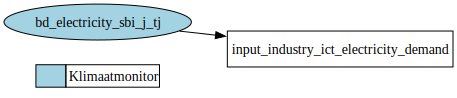

In [8]:
# Define ETLocal key
etlocal_key = "input_industry_ict_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Following function sets up a format for the commit message. Will later be moved to *src.helpers*.

Read the information for the commit message from the image and write them down to generate the commit message.

In [9]:

message = 'Based on Elektriciteitsverbruik SBI J (CBS, 2023)'

2. Calculate etlocal_key values
- *Action*: assign the output name from the image to `ivar`.

In [10]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline


input_industry_ict_electricity_demand error_message  \
GM0014                                 0.0000           NaN   
GM0034                               236.6028           NaN   
GM0037                                 4.8132           NaN   
GM0047                                 3.6720           NaN   
GM0050                                 5.8644           NaN   
...                                       ...           ...   
GM1979                                 6.2676           NaN   
GM1980                                13.3560           NaN   
GM1982                                16.9164           NaN   
GM1991                                10.4688           NaN   
GM1992                                 8.6040           NaN   

                                                   commit  
GM0014  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM0034  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM0037  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM0047  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM0050  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
...                                                   ...  
GM1979  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM1980  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM1982  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM1991  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  
GM1992  Based on Elektriciteitsverbruik SBI J (CBS, 2023)  

[342 rows x 3 columns]

3. Add data to template

In [11]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)


4. Use validation function to quick-scan data.

In [12]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_industry_ict_electricity_demand',
 'total_rows': 342,
 'zero_count': 5,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 3730.0428,
 'mean_value': 35.23049473684211,
 'median_value': 5.488200000000001}

In [13]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_industry_ict_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 257 municipalities (76.0%)
  medium_diff: 72 municipalities (21.3%)
  small_diff: 6 municipalities (1.8%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=3730.04, Mean=35.50
  Verification: Min=0.00, Max=2996.11, Mean=33.48
  Abs diff:     Min=0.00, Max=1962.05, Mean=11.55

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0394: Template=3730.04,

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


template_value verification_value absolute_diff  relative_diff  \
GM0394       3730.0428          1767.9924     1962.0504     110.976178   
GM1966          0.0000           421.3476      421.3476    -100.000000   
GM0014          0.0000           222.8418      222.8418    -100.000000   
GM0402         90.5148           193.6872      103.1724     -53.267537   
GM0363       2896.8516          2996.1108       99.2592      -3.312935   
...                ...                ...           ...            ...   
GM0965          1.5372             1.5264        0.0108       0.707547   
GM0317          2.1600             2.1708        0.0108      -0.497512   
GM1926          7.6356             7.6356           0.0       0.000000   
GM0358          0.0000                  0           0.0       0.000000   
GM0613          3.2652             3.2652           0.0       0.000000   

             status  
GM0394   large_diff  
GM1966   large_diff  
GM0014   large_diff  
GM0402   large_diff  
GM0363  medium_diff  
...             ...  
GM0965   small_diff  
GM0317   small_diff  
GM1926  exact_match  
GM0358  exact_match  
GM0613  exact_match  

[338 rows x 5 columns]

#### Aluminium

##### Metal alinium production


1. Generate image

- *Action*: assign the corresponding `etlocal_key`

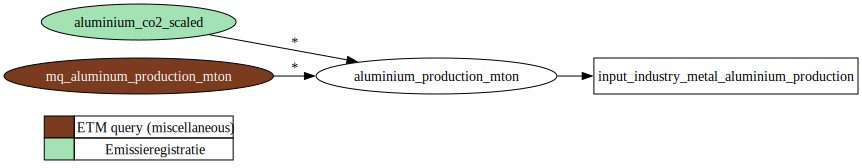

In [14]:
# Define ETLocal key
etlocal_key = "input_industry_metal_aluminium_production"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [15]:
# Generate commit message for metal aluminium production
message = generate_commit_message("Aluminium")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [16]:
# Calculate values for input_industry_metal_aluminium_production
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_aluminium_production  aluminium_production_mton  \
GM0014                                   0.000000                   0.000000   
GM0034                                   0.000000                   0.000000   
GM0037                                   0.000000                   0.000000   
GM0047                                   0.000000                   0.000000   
GM0050                                   0.000000                   0.000000   
...                                           ...                        ...   
GM1979                                   0.003957                   0.003957   
GM1980                                   0.000000                   0.000000   
GM1982                                   0.000091                   0.000091   
GM1991                                   0.000366                   0.000366   
GM1992                                   0.000000                   0.000000   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [17]:
# Add data to template for input_industry_metal_aluminium_production
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [18]:
# Validate data for input_industry_metal_aluminium_production
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_aluminium_production', 'total_rows': 342, 'zero_count': 279, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.016663549910488563, 'mean_value': 0.0003304093567251452, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [19]:
# Verify data for input_industry_metal_aluminium_production
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_aluminium_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 276 municipalities (81.7%)
  large_diff: 37 municipalities (10.9%)
  small_diff: 20 municipalities (5.9%)
  medium_diff: 5 municipalities (1.5%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.02, Mean=0.00
  Verification: Min=0.00, Max=0.08, Mean=0.00
  Abs diff:     Min=0.00, Max=0.08, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1979: Template=0.00, Verificat

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal aluminium electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

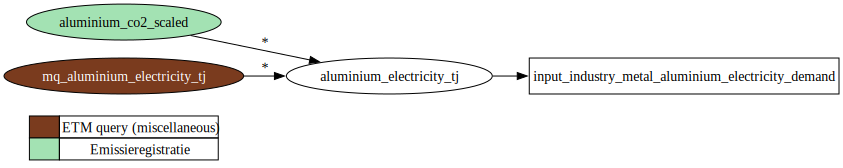

In [20]:
# Define ETLocal key
etlocal_key = "input_industry_metal_aluminium_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [21]:
# Generate commit message for metal aluminium electricity demand
message = generate_commit_message("Aluminium")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [22]:
# Calculate values for input_industry_metal_aluminium_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_aluminium_electricity_demand  \
GM0014                                           0.000000   
GM0034                                           0.000000   
GM0037                                           0.000000   
GM0047                                           0.000000   
GM0050                                           0.000000   
...                                                   ...   
GM1979                                          17.252148   
GM1980                                           0.000000   
GM1982                                           0.398649   
GM1991                                           1.594595   
GM1992                                           0.000000   

        aluminium_electricity_tj error_message  \
GM0014                  0.000000           NaN   
GM0034                  0.000000           NaN   
GM0037                  0.000000           NaN   
GM0047                  0.000000           NaN   
GM0050                  0.000000           NaN   
...                          ...           ...   
GM1979                 17.252148           NaN   
GM1980                  0.000000           NaN   
GM1982                  0.398649           NaN   
GM1991                  1.594595           NaN   
GM1992                  0.000000           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [23]:
# Add data to template for input_industry_metal_aluminium_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [24]:
# Validate data for input_industry_metal_aluminium_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_aluminium_electricity_demand', 'total_rows': 342, 'zero_count': 279, 'nan_count': 0, 'min_value': 0.0, 'max_value': 72.65307760972998, 'mean_value': 1.44058479532163, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [25]:
# Verify data for input_industry_metal_aluminium_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_aluminium_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 276 municipalities (81.7%)
  large_diff: 42 municipalities (12.4%)
  small_diff: 20 municipalities (5.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=72.65, Mean=1.45
  Verification: Min=0.00, Max=3281.39, Mean=17.07
  Abs diff:     Min=0.00, Max=3264.13, Mean=15.81

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1979: Template=17.25, Verification=3281.39, Diff=326

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal aluminium network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

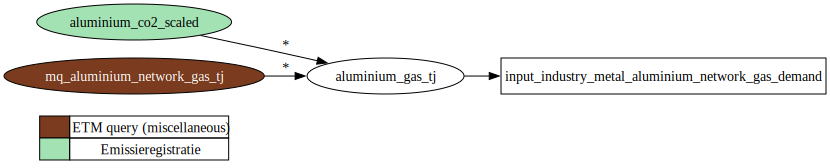

In [26]:
# Define ETLocal key
etlocal_key = "input_industry_metal_aluminium_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [27]:
# Generate commit message for metal aluminium network gas demand
message = generate_commit_message("Aluminium")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [28]:
# Calculate values for input_industry_metal_aluminium_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_aluminium_network_gas_demand  aluminium_gas_tj  \
GM0014                                           0.000000          0.000000   
GM0034                                           0.000000          0.000000   
GM0037                                           0.000000          0.000000   
GM0047                                           0.000000          0.000000   
GM0050                                           0.000000          0.000000   
...                                                   ...               ...   
GM1979                                          16.091453         16.091453   
GM1980                                           0.000000          0.000000   
GM1982                                           0.371828          0.371828   
GM1991                                           1.487313          1.487313   
GM1992                                           0.000000          0.000000   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [29]:
# Add data to template for input_industry_metal_aluminium_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [30]:
# Validate data for input_industry_metal_aluminium_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_aluminium_network_gas_demand', 'total_rows': 342, 'zero_count': 279, 'nan_count': 0, 'min_value': 0.0, 'max_value': 67.76510296932, 'mean_value': 1.3436647173489207, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [31]:
# Verify data for input_industry_metal_aluminium_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_aluminium_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 276 municipalities (81.7%)
  large_diff: 37 municipalities (10.9%)
  small_diff: 20 municipalities (5.9%)
  medium_diff: 5 municipalities (1.5%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=67.77, Mean=1.35
  Verification: Min=0.00, Max=345.26, Mean=1.80
  Abs diff:     Min=0.00, Max=329.17, Mean=1.56

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1979: Template=16

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Chemical

##### Chemical other electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

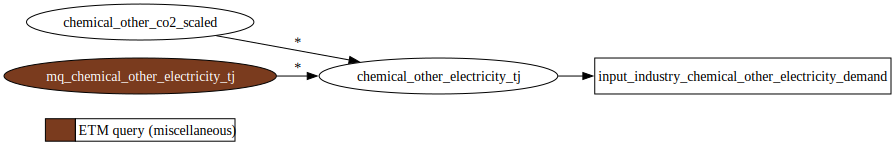

In [32]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [33]:
# Generate commit message for Chemical other electricity demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [34]:
# Calculate values for input_industry_chemical_other_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_electricity_demand  \
GM0014                                         11.367619   
GM0034                                          6.228218   
GM0037                                          1.686548   
GM0047                                         33.005685   
GM0050                                          3.697854   
...                                                  ...   
GM1979                                       1647.935532   
GM1980                                         10.640631   
GM1982                                          1.217587   
GM1991                                          8.827317   
GM1992                                          0.753442   

        chemical_other_electricity_tj error_message  \
GM0014                      11.367619           NaN   
GM0034                       6.228218           NaN   
GM0037                       1.686548           NaN   
GM0047                      33.005685           NaN   
GM0050                       3.697854           NaN   
...                               ...           ...   
GM1979                    1647.935532           NaN   
GM1980                      10.640631           NaN   
GM1982                       1.217587           NaN   
GM1991                       8.827317           NaN   
GM1992                       0.753442           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [35]:
# Add data to template for input_industry_chemical_other_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [36]:
# Validate data for input_industry_chemical_other_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_electricity_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 9922.045015573398, 'mean_value': 118.68764035087683, 'median_value': 0.66667137314635}


6. Verify data

- *Action*: compare with verification dataset

In [37]:
# Verify data for input_industry_chemical_other_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 318 municipalities (94.1%)
  medium_diff: 11 municipalities (3.3%)
  small_diff: 8 municipalities (2.4%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=9922.05, Mean=120.03
  Verification: Min=0.00, Max=4514.64, Mean=64.97
  Abs diff:     Min=0.00, Max=9456.96, Mean=90.09

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Templa

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

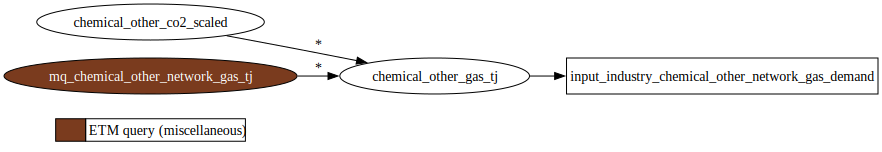

In [38]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [39]:
# Generate commit message for Chemical other network gas demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [40]:
# Calculate values for input_industry_chemical_other_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_network_gas_demand  \
GM0014                                         11.591672   
GM0034                                          6.350975   
GM0037                                          1.719790   
GM0047                                         33.656220   
GM0050                                          3.770738   
...                                                  ...   
GM1979                                       1680.415983   
GM1980                                         10.850356   
GM1982                                          1.241585   
GM1991                                          9.001301   
GM1992                                          0.768292   

        chemical_other_gas_tj error_message  \
GM0014              11.591672           NaN   
GM0034               6.350975           NaN   
GM0037               1.719790           NaN   
GM0047              33.656220           NaN   
GM0050               3.770738           NaN   
...                       ...           ...   
GM1979            1680.415983           NaN   
GM1980              10.850356           NaN   
GM1982               1.241585           NaN   
GM1991               9.001301           NaN   
GM1992               0.768292           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [41]:
# Add data to template for input_industry_chemical_other_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [42]:
# Validate data for input_industry_chemical_other_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_network_gas_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 10117.606369785797, 'mean_value': 121.02694798744372, 'median_value': 0.6798113212460115}


6. Verify data

- *Action*: compare with verification dataset

In [43]:
# Verify data for input_industry_chemical_other_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 325 municipalities (96.2%)
  medium_diff: 7 municipalities (2.1%)
  small_diff: 5 municipalities (1.5%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=10117.61, Mean=122.39
  Verification: Min=0.00, Max=66627.30, Mean=497.60
  Abs diff:     Min=0.00, Max=58784.97, Mean=375.55

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Te

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

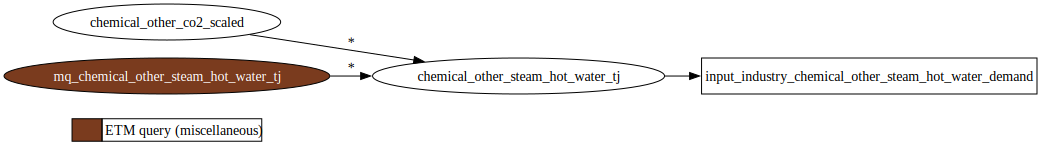

In [45]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [46]:
# Generate commit message for Chemical other steam hot water demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [47]:
# Calculate values for input_industry_chemical_other_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_steam_hot_water_demand  \
GM0014                                          13.731771      
GM0034                                           7.523516      
GM0037                                           2.037304      
GM0047                                          39.869960      
GM0050                                           4.466906      
...                                                   ...      
GM1979                                        1990.660803      
GM1980                                          12.853590      
GM1982                                           1.470812      
GM1991                                          10.663156      
GM1992                                           0.910137      

        chemical_other_steam_hot_water_tj error_message  \
GM0014                          13.731771           NaN   
GM0034                           7.523516           NaN   
GM0037                           2.037304           NaN   
GM0047                          39.869960           NaN   
GM0050                           4.466906           NaN   
...                                   ...           ...   
GM1979                        1990.660803           NaN   
GM1980                          12.853590           NaN   
GM1982                           1.470812           NaN   
GM1991                          10.663156           NaN   
GM1992                           0.910137           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [48]:
# Add data to template for input_industry_chemical_other_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [49]:
# Validate data for input_industry_chemical_other_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 11985.557514941647, 'mean_value': 143.37140554244243, 'median_value': 0.805320684785155}


6. Verify data

- *Action*: compare with verification dataset

In [50]:
# Verify data for input_industry_chemical_other_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 337 municipalities (99.7%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=11985.56, Mean=144.99
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=11985.56, Mean=144.99

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=11985.56, Verification=0.00, Diff=11985.56 (0.0%)
  Municipality GM1883:

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

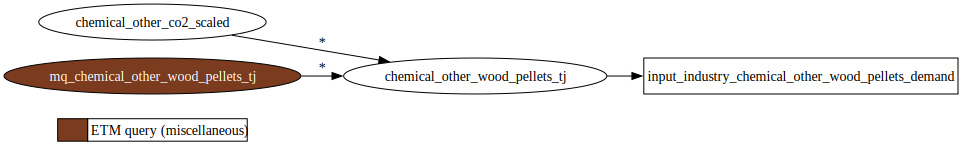

In [51]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [52]:
# Generate commit message for Chemical other wood pellets demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [53]:
# Calculate values for input_industry_chemical_other_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_wood_pellets_demand  \
GM0014                                                0.0   
GM0034                                                0.0   
GM0037                                                0.0   
GM0047                                                0.0   
GM0050                                                0.0   
...                                                   ...   
GM1979                                                0.0   
GM1980                                                0.0   
GM1982                                                0.0   
GM1991                                                0.0   
GM1992                                                0.0   

        chemical_other_wood_pellets_tj error_message  \
GM0014                             0.0           NaN   
GM0034                             0.0           NaN   
GM0037                             0.0           NaN   
GM0047                             0.0           NaN   
GM0050                             0.0           NaN   
...                                ...           ...   
GM1979                             0.0           NaN   
GM1980                             0.0           NaN   
GM1982                             0.0           NaN   
GM1991                             0.0           NaN   
GM1992                             0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [54]:
# Add data to template for input_industry_chemical_other_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [55]:
# Validate data for input_industry_chemical_other_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [56]:
# Verify data for input_industry_chemical_other_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Munici

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

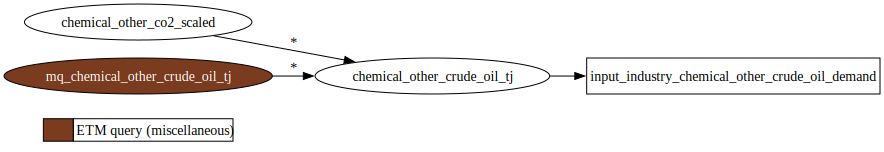

In [57]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [58]:
# Generate commit message for Chemical other crude oil demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [59]:
# Calculate values for input_industry_chemical_other_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_crude_oil_demand  \
GM0014                                       29.227485   
GM0034                                       16.013480   
GM0037                                        4.336314   
GM0047                                       84.861497   
GM0050                                        9.507618   
...                                                ...   
GM1979                                     4237.036046   
GM1980                                       27.358315   
GM1982                                        3.130560   
GM1991                                       22.696069   
GM1992                                        1.937188   

        chemical_other_crude_oil_tj error_message  \
GM0014                    29.227485           NaN   
GM0034                    16.013480           NaN   
GM0037                     4.336314           NaN   
GM0047                    84.861497           NaN   
GM0050                     9.507618           NaN   
...                             ...           ...   
GM1979                  4237.036046           NaN   
GM1980                    27.358315           NaN   
GM1982                     3.130560           NaN   
GM1991                    22.696069           NaN   
GM1992                     1.937188           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [60]:
# Add data to template for input_industry_chemical_other_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [61]:
# Validate data for input_industry_chemical_other_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_crude_oil_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 25510.744547312384, 'mean_value': 305.1598807667299, 'median_value': 1.7140904995541035}


6. Verify data

- *Action*: compare with verification dataset

In [62]:
# Verify data for input_industry_chemical_other_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 337 municipalities (99.7%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=25510.74, Mean=308.61
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=25510.74, Mean=308.61

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=25510.74, Verification=0.00, Diff=25510.74 (0.0%)
  Municipality GM1883: Templ

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

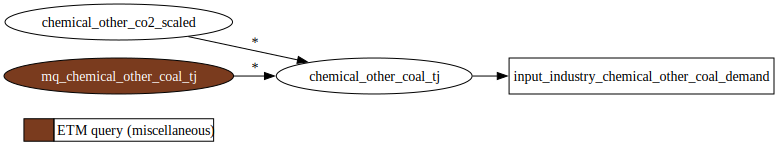

In [63]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [64]:
# Generate commit message for Chemical other coal demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [65]:
# Calculate values for input_industry_chemical_other_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_coal_demand  chemical_other_coal_tj  \
GM0014                                        0.0                     0.0   
GM0034                                        0.0                     0.0   
GM0037                                        0.0                     0.0   
GM0047                                        0.0                     0.0   
GM0050                                        0.0                     0.0   
...                                           ...                     ...   
GM1979                                        0.0                     0.0   
GM1980                                        0.0                     0.0   
GM1982                                        0.0                     0.0   
GM1991                                        0.0                     0.0   
GM1992                                        0.0                     0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [66]:
# Add data to template for input_industry_chemical_other_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [67]:
# Validate data for input_industry_chemical_other_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [68]:
# Verify data for input_industry_chemical_other_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality G

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

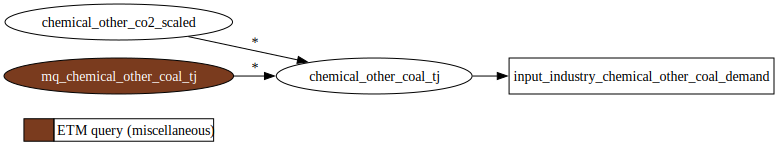

In [69]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [70]:
# Generate commit message for Chemical other coal demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [71]:
# Calculate values for input_industry_chemical_other_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_coal_demand  chemical_other_coal_tj  \
GM0014                                        0.0                     0.0   
GM0034                                        0.0                     0.0   
GM0037                                        0.0                     0.0   
GM0047                                        0.0                     0.0   
GM0050                                        0.0                     0.0   
...                                           ...                     ...   
GM1979                                        0.0                     0.0   
GM1980                                        0.0                     0.0   
GM1982                                        0.0                     0.0   
GM1991                                        0.0                     0.0   
GM1992                                        0.0                     0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [72]:
# Add data to template for input_industry_chemical_other_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [73]:
# Validate data for input_industry_chemical_other_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [74]:
# Verify data for input_industry_chemical_other_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality G

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other naphtha demand

In [75]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_naphtha_demand"
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_naphtha_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Chemical other naphtha non energetic demand

In [76]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_naphtha_non_energetic_demand"
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_naphtha_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Chemical other wood pellets non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

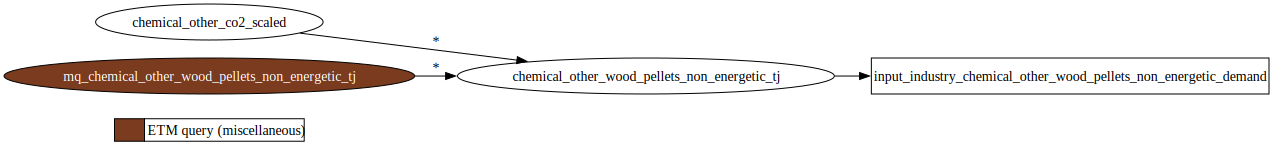

In [77]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_wood_pellets_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [78]:
# Generate commit message for Chemical other wood pellets non energetic demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [79]:
# Calculate values for input_industry_chemical_other_wood_pellets_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_wood_pellets_non_energetic_demand  \
GM0014                                                0.0                 
GM0034                                                0.0                 
GM0037                                                0.0                 
GM0047                                                0.0                 
GM0050                                                0.0                 
...                                                   ...                 
GM1979                                                0.0                 
GM1980                                                0.0                 
GM1982                                                0.0                 
GM1991                                                0.0                 
GM1992                                                0.0                 

        chemical_other_wood_pellets_non_energetic_tj error_message  \
GM0014                                           0.0           NaN   
GM0034                                           0.0           NaN   
GM0037                                           0.0           NaN   
GM0047                                           0.0           NaN   
GM0050                                           0.0           NaN   
...                                              ...           ...   
GM1979                                           0.0           NaN   
GM1980                                           0.0           NaN   
GM1982                                           0.0           NaN   
GM1991                                           0.0           NaN   
GM1992                                           0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [80]:
# Add data to template for input_industry_chemical_other_wood_pellets_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [81]:
# Validate data for input_industry_chemical_other_wood_pellets_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_wood_pellets_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [82]:
# Verify data for input_industry_chemical_other_wood_pellets_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_wood_pellets_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other network gas non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

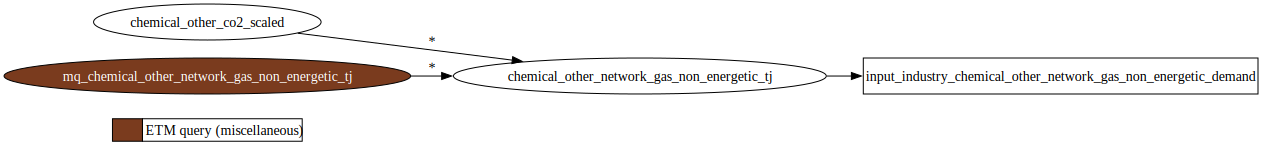

In [83]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_network_gas_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [84]:
# Generate commit message for Chemical other wood pellets non energetic demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [85]:
# Calculate values for input_industry_chemical_other_wood_pellets_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_network_gas_non_energetic_demand  \
GM0014                                           4.670921                
GM0034                                           2.559156                
GM0037                                           0.692998                
GM0047                                          13.561938                
GM0050                                           1.519437                
...                                                   ...                
GM1979                                         677.131839                
GM1980                                           4.372204                
GM1982                                           0.500303                
GM1991                                           3.627118                
GM1992                                           0.309587                

        chemical_other_network_gas_non_energetic_tj error_message  \
GM0014                                     4.670921           NaN   
GM0034                                     2.559156           NaN   
GM0037                                     0.692998           NaN   
GM0047                                    13.561938           NaN   
GM0050                                     1.519437           NaN   
...                                             ...           ...   
GM1979                                   677.131839           NaN   
GM1980                                     4.372204           NaN   
GM1982                                     0.500303           NaN   
GM1991                                     3.627118           NaN   
GM1992                                     0.309587           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [86]:
# Add data to template for input_industry_chemical_other_wood_pellets_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [87]:
# Validate data for input_industry_chemical_other_wood_pellets_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_network_gas_non_energetic_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 4076.938967775831, 'mean_value': 48.76840058479508, 'median_value': 0.27393329657494037}


6. Verify data

- *Action*: compare with verification dataset

In [88]:
# Verify data for input_industry_chemical_other_wood_pellets_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_network_gas_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 337 municipalities (99.7%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=4076.94, Mean=49.32
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=4076.94, Mean=49.32

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=4076.94, Verification=0.00, Diff=4076.94 (0.0%)
  Municipality GM1

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other crude oil non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

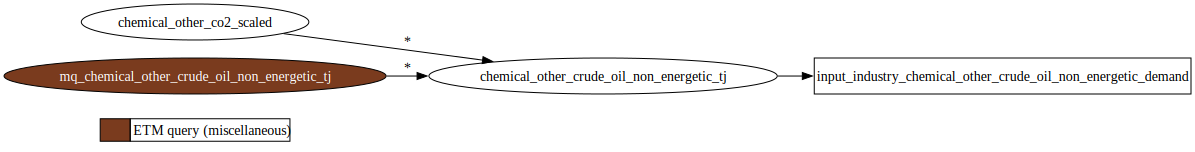

In [89]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_crude_oil_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [90]:
# Generate commit message for Chemical other crude oil non energetic demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [91]:
# Calculate values for input_industry_chemical_other_crude_oil_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_crude_oil_non_energetic_demand  \
GM0014                                          56.343005              
GM0034                                          30.869834              
GM0037                                           8.359289              
GM0047                                         163.590943              
GM0050                                          18.328221              
...                                                   ...              
GM1979                                        8167.905895              
GM1980                                          52.739731              
GM1982                                           6.034907              
GM1991                                          43.752132              
GM1992                                           3.734395              

        chemical_other_crude_oil_non_energetic_tj error_message  \
GM0014                                  56.343005           NaN   
GM0034                                  30.869834           NaN   
GM0037                                   8.359289           NaN   
GM0047                                 163.590943           NaN   
GM0050                                  18.328221           NaN   
...                                           ...           ...   
GM1979                                8167.905895           NaN   
GM1980                                  52.739731           NaN   
GM1982                                   6.034907           NaN   
GM1991                                  43.752132           NaN   
GM1992                                   3.734395           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [92]:
# Add data to template for input_industry_chemical_other_crude_oil_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [93]:
# Validate data for input_industry_chemical_other_crude_oil_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_crude_oil_non_energetic_demand', 'total_rows': 342, 'zero_count': 1, 'nan_count': 0, 'min_value': 0.0, 'max_value': 49178.09490728712, 'mean_value': 588.2690546491204, 'median_value': 3.3043216402569344}


6. Verify data

- *Action*: compare with verification dataset

In [94]:
# Verify data for input_industry_chemical_other_crude_oil_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_crude_oil_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 337 municipalities (99.7%)
  exact_match: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=49178.09, Mean=594.92
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=49178.09, Mean=594.92

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=49178.09, Verification=0.00, Diff=49178.09 (0.0%)
  Municipality

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Chemical other coal non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

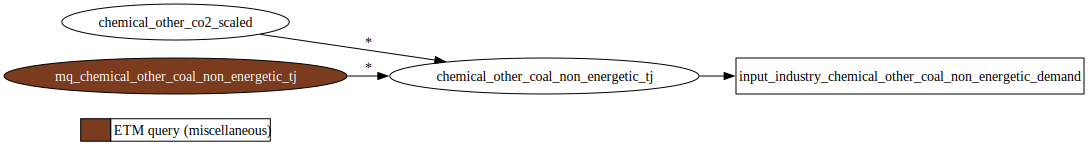

In [95]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_other_coal_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [96]:
# Generate commit message for Chemical other coal non energetic demand
message = generate_commit_message("Chemical other")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [97]:
# Calculate values for input_industry_chemical_other_coal_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_other_coal_non_energetic_demand  \
GM0014                                                0.0         
GM0034                                                0.0         
GM0037                                                0.0         
GM0047                                                0.0         
GM0050                                                0.0         
...                                                   ...         
GM1979                                                0.0         
GM1980                                                0.0         
GM1982                                                0.0         
GM1991                                                0.0         
GM1992                                                0.0         

        chemical_other_coal_non_energetic_tj error_message  \
GM0014                                   0.0           NaN   
GM0034                                   0.0           NaN   
GM0037                                   0.0           NaN   
GM0047                                   0.0           NaN   
GM0050                                   0.0           NaN   
...                                      ...           ...   
GM1979                                   0.0           NaN   
GM1980                                   0.0           NaN   
GM1982                                   0.0           NaN   
GM1991                                   0.0           NaN   
GM1992                                   0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [98]:
# Add data to template for input_industry_chemical_other_coal_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [99]:
# Validate data for input_industry_chemical_other_coal_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_other_coal_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [100]:
# Verify data for input_industry_chemical_other_coal_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_other_coal_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Fertilizers

##### chemical fertilizers electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

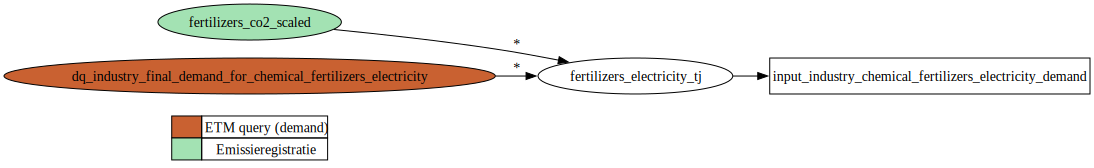

In [101]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [102]:
# Generate commit message for chemical fertilizers electricity demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [103]:
# Calculate values for input_industry_chemical_fertilizers_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_electricity_demand  \
GM0014                                                0.0        
GM0034                                                0.0        
GM0037                                                0.0        
GM0047                                                0.0        
GM0050                                                0.0        
...                                                   ...        
GM1979                                                0.0        
GM1980                                                0.0        
GM1982                                                0.0        
GM1991                                                0.0        
GM1992                                                0.0        

        fertilizers_electricity_tj error_message  \
GM0014                         0.0           NaN   
GM0034                         0.0           NaN   
GM0037                         0.0           NaN   
GM0047                         0.0           NaN   
GM0050                         0.0           NaN   
...                            ...           ...   
GM1979                         0.0           NaN   
GM1980                         0.0           NaN   
GM1982                         0.0           NaN   
GM1991                         0.0           NaN   
GM1992                         0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [104]:
# Add data to template for input_industry_chemical_fertilizers_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [105]:
# Validate data for input_industry_chemical_fertilizers_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_electricity_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2574.5848036419156, 'mean_value': 7.602339181286548, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [106]:
# Verify data for input_industry_chemical_fertilizers_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 333 municipalities (98.5%)
  large_diff: 4 municipalities (1.2%)
  small_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2574.58, Mean=7.69
  Verification: Min=0.00, Max=1494.00, Mean=8.88
  Abs diff:     Min=0.00, Max=1494.00, Mean=7.65

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1883: Template=0.00, Verification=1494.00, Diff=14

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

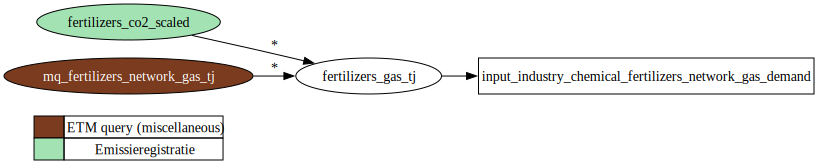

In [107]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [108]:
# Generate commit message for chemical fertilizers network gas demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [109]:
# Calculate values for input_industry_chemical_fertilizers_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_network_gas_demand  \
GM0014                                                0.0        
GM0034                                                0.0        
GM0037                                                0.0        
GM0047                                                0.0        
GM0050                                                0.0        
...                                                   ...        
GM1979                                                0.0        
GM1980                                                0.0        
GM1982                                                0.0        
GM1991                                                0.0        
GM1992                                                0.0        

        fertilizers_gas_tj error_message  \
GM0014                 0.0           NaN   
GM0034                 0.0           NaN   
GM0037                 0.0           NaN   
GM0047                 0.0           NaN   
GM0050                 0.0           NaN   
...                    ...           ...   
GM1979                 0.0           NaN   
GM1980                 0.0           NaN   
GM1982                 0.0           NaN   
GM1991                 0.0           NaN   
GM1992                 0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [110]:
# Add data to template for input_industry_chemical_fertilizers_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [111]:
# Validate data for input_industry_chemical_fertilizers_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_network_gas_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 15447.508821851534, 'mean_value': 45.6140350877194, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [112]:
# Verify data for input_industry_chemical_fertilizers_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 333 municipalities (98.5%)
  large_diff: 4 municipalities (1.2%)
  small_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=15447.51, Mean=46.15
  Verification: Min=0.00, Max=11254.80, Mean=66.93
  Abs diff:     Min=0.00, Max=11254.80, Mean=45.82

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1883: Template=0.00, Verification=11254.80, 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

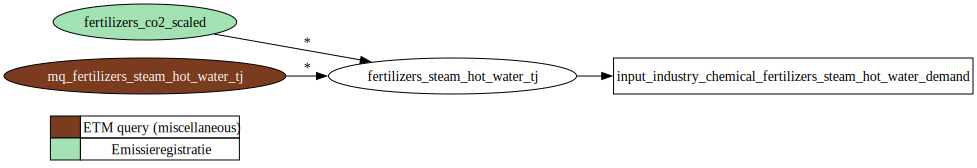

In [113]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [114]:
# Generate commit message for chemical fertilizers steam hot water demand
message = 'Automated calculation for chemical fertilizers steam hot water demand' 

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [115]:
# Calculate values for input_industry_chemical_fertilizers_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_steam_hot_water_demand  \
GM0014                                                0.0            
GM0034                                                0.0            
GM0037                                                0.0            
GM0047                                                0.0            
GM0050                                                0.0            
...                                                   ...            
GM1979                                                0.0            
GM1980                                                0.0            
GM1982                                                0.0            
GM1991                                                0.0            
GM1992                                                0.0            

        fertilizers_steam_hot_water_tj error_message  \
GM0014                             0.0           NaN   
GM0034                             0.0           NaN   
GM0037                             0.0           NaN   
GM0047                             0.0           NaN   
GM0050                             0.0           NaN   
...                                ...           ...   
GM1979                             0.0           NaN   
GM1980                             0.0           NaN   
GM1982                             0.0           NaN   
GM1991                             0.0           NaN   
GM1992                             0.0           NaN   

                                                   commit  
GM0014  Automated calculation for chemical fertilizers...  
GM0034  Automated calculation for chemical fertilizers...  
GM0037  Automated calculation for chemical fertilizers...  
GM0047  Automated calculation for chemical fertilizers...  
GM0050  Automated calculation for chemical fertilizers...  
...                                                   ...  
GM1979  Automated calculation for chemical fertilizers...  
GM1980  Automated calculation for chemical fertilizers...  
GM1982  Automated calculation for chemical fertilizers...  
GM1991  Automated calculation for chemical fertilizers...  
GM1992  Automated calculation for chemical fertilizers...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [116]:
# Add data to template for input_industry_chemical_fertilizers_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [117]:
# Validate data for input_industry_chemical_fertilizers_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 3663.832220567352, 'mean_value': 10.818713450292426, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [118]:
# Verify data for input_industry_chemical_fertilizers_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 333 municipalities (98.5%)
  large_diff: 4 municipalities (1.2%)
  small_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=3663.83, Mean=10.95
  Verification: Min=0.00, Max=2739.00, Mean=16.29
  Abs diff:     Min=0.00, Max=2739.00, Mean=10.87

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1883: Template=0.00, Verification=2739.00, 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

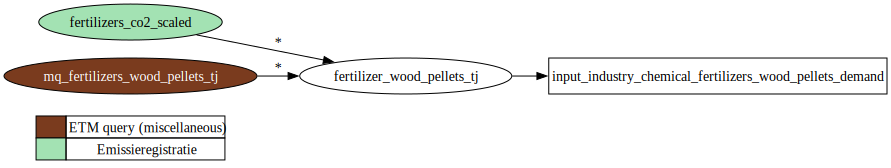

In [119]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [120]:
# Generate commit message for chemical fertilizers wood pellets demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [121]:
# Calculate values for input_industry_chemical_fertilizers_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_wood_pellets_demand  \
GM0014                                                0.0         
GM0034                                                0.0         
GM0037                                                0.0         
GM0047                                                0.0         
GM0050                                                0.0         
...                                                   ...         
GM1979                                                0.0         
GM1980                                                0.0         
GM1982                                                0.0         
GM1991                                                0.0         
GM1992                                                0.0         

        fertilizer_wood_pellets_tj error_message  \
GM0014                         0.0           NaN   
GM0034                         0.0           NaN   
GM0037                         0.0           NaN   
GM0047                         0.0           NaN   
GM0050                         0.0           NaN   
...                            ...           ...   
GM1979                         0.0           NaN   
GM1980                         0.0           NaN   
GM1982                         0.0           NaN   
GM1991                         0.0           NaN   
GM1992                         0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [122]:
# Add data to template for input_industry_chemical_fertilizers_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [123]:
# Validate data for input_industry_chemical_fertilizers_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [124]:
# Verify data for input_industry_chemical_fertilizers_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

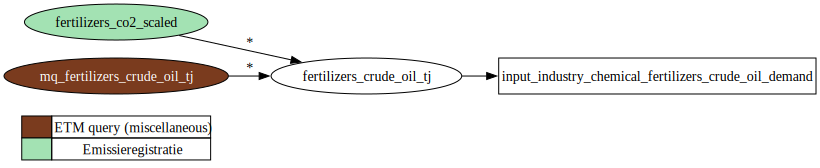

In [125]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [126]:
# Generate commit message for chemical fertilizers crude oil demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [127]:
# Calculate values for input_industry_chemical_fertilizers_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_crude_oil_demand  \
GM0014                                                0.0      
GM0034                                                0.0      
GM0037                                                0.0      
GM0047                                                0.0      
GM0050                                                0.0      
...                                                   ...      
GM1979                                                0.0      
GM1980                                                0.0      
GM1982                                                0.0      
GM1991                                                0.0      
GM1992                                                0.0      

        fertilizers_crude_oil_tj error_message  \
GM0014                       0.0           NaN   
GM0034                       0.0           NaN   
GM0037                       0.0           NaN   
GM0047                       0.0           NaN   
GM0050                       0.0           NaN   
...                          ...           ...   
GM1979                       0.0           NaN   
GM1980                       0.0           NaN   
GM1982                       0.0           NaN   
GM1991                       0.0           NaN   
GM1992                       0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [128]:
# Add data to template for input_industry_chemical_fertilizers_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [129]:
# Validate data for input_industry_chemical_fertilizers_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_crude_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [130]:
# Verify data for input_industry_chemical_fertilizers_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Mun

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

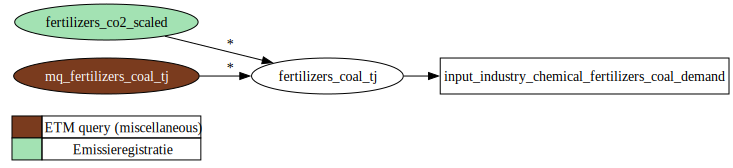

In [131]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [132]:
# Generate commit message for chemical fertilizers coal demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [133]:
# Calculate values for input_industry_chemical_fertilizers_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_coal_demand  fertilizers_coal_tj  \
GM0014                                              0.0                  0.0   
GM0034                                              0.0                  0.0   
GM0037                                              0.0                  0.0   
GM0047                                              0.0                  0.0   
GM0050                                              0.0                  0.0   
...                                                 ...                  ...   
GM1979                                              0.0                  0.0   
GM1980                                              0.0                  0.0   
GM1982                                              0.0                  0.0   
GM1991                                              0.0                  0.0   
GM1992                                              0.0                  0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [134]:
# Add data to template for input_industry_chemical_fertilizers_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [135]:
# Validate data for input_industry_chemical_fertilizers_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [136]:
# Verify data for input_industry_chemical_fertilizers_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipa

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers network gas non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

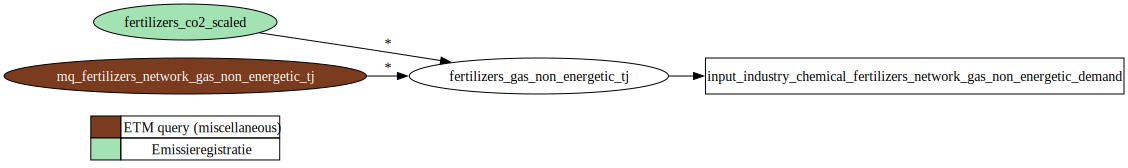

In [137]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_network_gas_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [138]:
# Generate commit message for chemical fertilizers network gas non energetic demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [139]:
# Calculate values for input_industry_chemical_fertilizers_network_gas_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_network_gas_non_energetic_demand  \
GM0014                                                0.0                      
GM0034                                                0.0                      
GM0037                                                0.0                      
GM0047                                                0.0                      
GM0050                                                0.0                      
...                                                   ...                      
GM1979                                                0.0                      
GM1980                                                0.0                      
GM1982                                                0.0                      
GM1991                                                0.0                      
GM1992                                                0.0                      

        fertilizers_gas_non_energetic_tj error_message  \
GM0014                               0.0           NaN   
GM0034                               0.0           NaN   
GM0037                               0.0           NaN   
GM0047                               0.0           NaN   
GM0050                               0.0           NaN   
...                                  ...           ...   
GM1979                               0.0           NaN   
GM1980                               0.0           NaN   
GM1982                               0.0           NaN   
GM1991                               0.0           NaN   
GM1992                               0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [140]:
# Add data to template for input_industry_chemical_fertilizers_network_gas_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [141]:
# Validate data for input_industry_chemical_fertilizers_network_gas_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_network_gas_non_energetic_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 49808.31370122647, 'mean_value': 147.07602339181335, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [142]:
# Verify data for input_industry_chemical_fertilizers_network_gas_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_network_gas_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 333 municipalities (98.5%)
  large_diff: 4 municipalities (1.2%)
  small_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=49808.31, Mean=148.82
  Verification: Min=0.00, Max=31822.20, Mean=189.24
  Abs diff:     Min=0.00, Max=31822.20, Mean=147.87

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1883: Template=0.00, Verifi

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers wood pellets non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

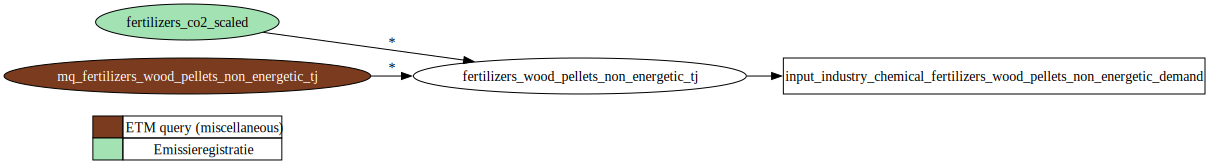

In [143]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [144]:
# Generate commit message for chemical fertilizers wood pellets non energetic demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [145]:
# Calculate values for input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand  \
GM0014                                                0.0                       
GM0034                                                0.0                       
GM0037                                                0.0                       
GM0047                                                0.0                       
GM0050                                                0.0                       
...                                                   ...                       
GM1979                                                0.0                       
GM1980                                                0.0                       
GM1982                                                0.0                       
GM1991                                                0.0                       
GM1992                                                0.0                       

        fertilizers_wood_pellets_non_energetic_tj error_message  \
GM0014                                        0.0           NaN   
GM0034                                        0.0           NaN   
GM0037                                        0.0           NaN   
GM0047                                        0.0           NaN   
GM0050                                        0.0           NaN   
...                                           ...           ...   
GM1979                                        0.0           NaN   
GM1980                                        0.0           NaN   
GM1982                                        0.0           NaN   
GM1991                                        0.0           NaN   
GM1992                                        0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [146]:
# Add data to template for input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [147]:
# Validate data for input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [148]:
# Verify data for input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_wood_pellets_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers crude oil non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

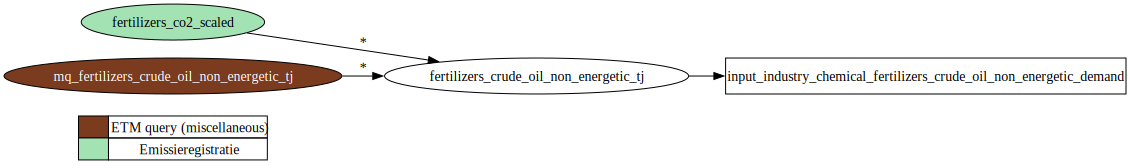

In [149]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_crude_oil_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [150]:
# Generate commit message for chemical fertilizers crude oil non energetic demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [151]:
# Calculate values for input_industry_chemical_fertilizers_crude_oil_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_crude_oil_non_energetic_demand  \
GM0014                                                0.0                    
GM0034                                                0.0                    
GM0037                                                0.0                    
GM0047                                                0.0                    
GM0050                                                0.0                    
...                                                   ...                    
GM1979                                                0.0                    
GM1980                                                0.0                    
GM1982                                                0.0                    
GM1991                                                0.0                    
GM1992                                                0.0                    

        fertilizers_crude_oil_non_energetic_tj error_message  \
GM0014                                     0.0           NaN   
GM0034                                     0.0           NaN   
GM0037                                     0.0           NaN   
GM0047                                     0.0           NaN   
GM0050                                     0.0           NaN   
...                                        ...           ...   
GM1979                                     0.0           NaN   
GM1980                                     0.0           NaN   
GM1982                                     0.0           NaN   
GM1991                                     0.0           NaN   
GM1992                                     0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [152]:
# Add data to template for input_industry_chemical_fertilizers_crude_oil_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [153]:
# Validate data for input_industry_chemical_fertilizers_crude_oil_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_crude_oil_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [154]:
# Verify data for input_industry_chemical_fertilizers_crude_oil_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_crude_oil_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers coal non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

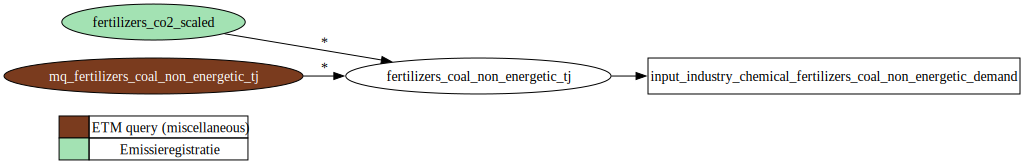

In [155]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_coal_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [156]:
# Generate commit message for chemical fertilizers coal non energetic demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [157]:
# Calculate values for input_industry_chemical_fertilizers_coal_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_coal_non_energetic_demand  \
GM0014                                                0.0               
GM0034                                                0.0               
GM0037                                                0.0               
GM0047                                                0.0               
GM0050                                                0.0               
...                                                   ...               
GM1979                                                0.0               
GM1980                                                0.0               
GM1982                                                0.0               
GM1991                                                0.0               
GM1992                                                0.0               

        fertilizers_coal_non_energetic_tj error_message  \
GM0014                                0.0           NaN   
GM0034                                0.0           NaN   
GM0037                                0.0           NaN   
GM0047                                0.0           NaN   
GM0050                                0.0           NaN   
...                                   ...           ...   
GM1979                                0.0           NaN   
GM1980                                0.0           NaN   
GM1982                                0.0           NaN   
GM1991                                0.0           NaN   
GM1992                                0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [158]:
# Add data to template for input_industry_chemical_fertilizers_coal_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [159]:
# Validate data for input_industry_chemical_fertilizers_coal_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_coal_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [160]:
# Verify data for input_industry_chemical_fertilizers_coal_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_coal_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical fertilizers hydrogen non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

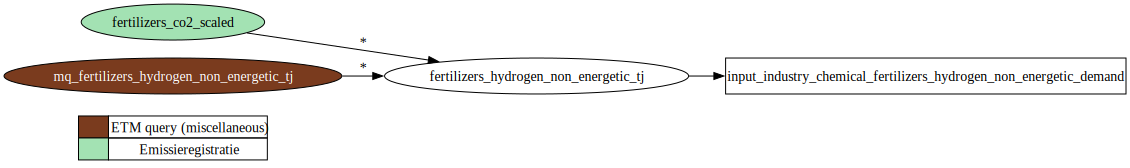

In [161]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_fertilizers_hydrogen_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [162]:
# Generate commit message for chemical fertilizers hydrogen non energetic demand
message = generate_commit_message("Fertilizers")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [163]:
# Calculate values for input_industry_chemical_fertilizers_hydrogen_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_fertilizers_hydrogen_non_energetic_demand  \
GM0014                                                0.0                   
GM0034                                                0.0                   
GM0037                                                0.0                   
GM0047                                                0.0                   
GM0050                                                0.0                   
...                                                   ...                   
GM1979                                                0.0                   
GM1980                                                0.0                   
GM1982                                                0.0                   
GM1991                                                0.0                   
GM1992                                                0.0                   

        fertilizers_hydrogen_non_energetic_tj error_message  \
GM0014                                    0.0           NaN   
GM0034                                    0.0           NaN   
GM0037                                    0.0           NaN   
GM0047                                    0.0           NaN   
GM0050                                    0.0           NaN   
...                                       ...           ...   
GM1979                                    0.0           NaN   
GM1980                                    0.0           NaN   
GM1982                                    0.0           NaN   
GM1991                                    0.0           NaN   
GM1992                                    0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [164]:
# Add data to template for input_industry_chemical_fertilizers_hydrogen_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [165]:
# Validate data for input_industry_chemical_fertilizers_hydrogen_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_fertilizers_hydrogen_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [166]:
# Verify data for input_industry_chemical_fertilizers_hydrogen_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_fertilizers_hydrogen_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Food

##### food electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

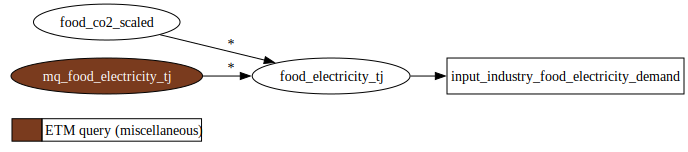

In [167]:
# Define ETLocal key
etlocal_key = "input_industry_food_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [168]:
# Generate commit message for food electricity demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [169]:
# Calculate values for input_industry_food_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_electricity_demand  food_electricity_tj  \
GM0014                             1018.895288          1018.895288   
GM0034                               50.885418            50.885418   
GM0037                                9.863524             9.863524   
GM0047                                6.913685             6.913685   
GM0050                               20.648873            20.648873   
...                                        ...                  ...   
GM1979                                8.112057             8.112057   
GM1980                               60.748247            60.748247   
GM1982                               59.918462            59.918462   
GM1991                               69.841903            69.841903   
GM1992                              233.025082           233.025082   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [170]:
# Add data to template for input_industry_food_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [171]:
# Validate data for input_industry_food_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_electricity_demand', 'total_rows': 342, 'zero_count': 3, 'nan_count': 0, 'min_value': 0.0, 'max_value': 1516.000147415162, 'mean_value': 70.79867251461881, 'median_value': 15.71711093674653}


6. Verify data

- *Action*: compare with verification dataset

In [172]:
# Verify data for input_industry_food_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 307 municipalities (90.8%)
  medium_diff: 22 municipalities (6.5%)
  small_diff: 6 municipalities (1.8%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1516.00, Mean=70.38
  Verification: Min=0.00, Max=1238.11, Mean=75.29
  Abs diff:     Min=0.00, Max=1480.92, Mean=59.29

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=1516.00,

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### food network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

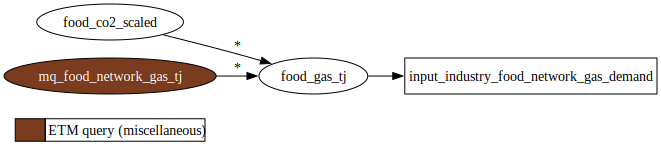

In [173]:
# Define ETLocal key
etlocal_key = "input_industry_food_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [174]:
# Generate commit message for food network gas demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [175]:
# Calculate values for input_industry_food_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_network_gas_demand  food_gas_tj error_message  \
GM0014                             2083.280930  2083.280930           NaN   
GM0034                              104.042704   104.042704           NaN   
GM0037                               20.167423    20.167423           NaN   
GM0047                               14.136044    14.136044           NaN   
GM0050                               42.219651    42.219651           NaN   
...                                        ...          ...           ...   
GM1979                               16.586291    16.586291           NaN   
GM1980                              124.208705   124.208705           NaN   
GM1982                              122.512089   122.512089           NaN   
GM1991                              142.802020   142.802020           NaN   
GM1992                              476.453975   476.453975           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [176]:
# Add data to template for input_industry_food_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [177]:
# Validate data for input_industry_food_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_network_gas_demand', 'total_rows': 342, 'zero_count': 3, 'nan_count': 0, 'min_value': 0.0, 'max_value': 3099.6847627524357, 'mean_value': 144.75827511681993, 'median_value': 32.13593967532858}


6. Verify data

- *Action*: compare with verification dataset

In [178]:
# Verify data for input_industry_food_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 290 municipalities (85.8%)
  medium_diff: 39 municipalities (11.5%)
  small_diff: 6 municipalities (1.8%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=3099.68, Mean=143.91
  Verification: Min=0.00, Max=5199.46, Mean=177.36
  Abs diff:     Min=0.00, Max=2158.57, Mean=71.61

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=3040.

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### food steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

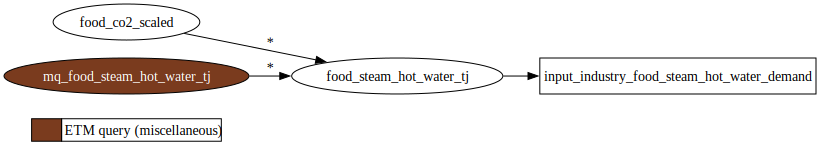

In [179]:
# Define ETLocal key
etlocal_key = "input_industry_food_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [180]:
# Generate commit message for food steam hot water demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [181]:
# Calculate values for input_industry_food_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_steam_hot_water_demand  food_steam_hot_water_tj  \
GM0014                                  152.195111               152.195111   
GM0034                                    7.600891                 7.600891   
GM0037                                    1.473341                 1.473341   
GM0047                                    1.032716                 1.032716   
GM0050                                    3.084377                 3.084377   
...                                            ...                      ...   
GM1979                                    1.211720                 1.211720   
GM1980                                    9.074128                 9.074128   
GM1982                                    8.950181                 8.950181   
GM1991                                   10.432472                10.432472   
GM1992                                   34.807579                34.807579   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [182]:
# Add data to template for input_industry_food_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [183]:
# Validate data for input_industry_food_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 3, 'nan_count': 0, 'min_value': 0.0, 'max_value': 226.44899226967212, 'mean_value': 10.57538686411187, 'median_value': 2.3477068515364827}


6. Verify data

- *Action*: compare with verification dataset

In [184]:
# Verify data for input_industry_food_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=226.45, Mean=10.51
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=226.45, Mean=10.51

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=226.45, Verification=0.00, Diff=226.45 (0.0%)
  Municipality GM0599: Template=222.15, Ve

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### food wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

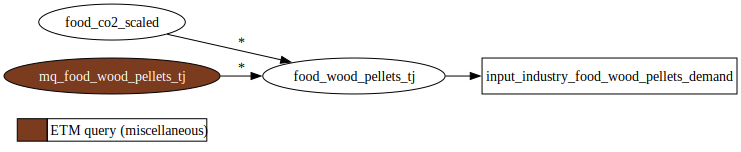

In [185]:
# Define ETLocal key
etlocal_key = "input_industry_food_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [186]:
# Generate commit message for food wood pellets demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [187]:
# Calculate values for input_industry_food_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_wood_pellets_demand  food_wood_pellets_tj  \
GM0014                                      0.0                   0.0   
GM0034                                      0.0                   0.0   
GM0037                                      0.0                   0.0   
GM0047                                      0.0                   0.0   
GM0050                                      0.0                   0.0   
...                                         ...                   ...   
GM1979                                      0.0                   0.0   
GM1980                                      0.0                   0.0   
GM1982                                      0.0                   0.0   
GM1991                                      0.0                   0.0   
GM1992                                      0.0                   0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [188]:
# Add data to template for input_industry_food_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [189]:
# Validate data for input_industry_food_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [190]:
# Verify data for input_industry_food_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### food crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

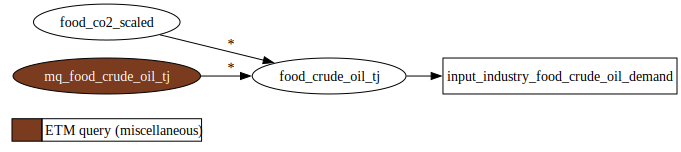

In [191]:
# Define ETLocal key
etlocal_key = "input_industry_food_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [192]:
# Generate commit message for food crude oil demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [193]:
# Calculate values for input_industry_food_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_crude_oil_demand  food_crude_oil_tj error_message  \
GM0014                              0.007027           0.007027           NaN   
GM0034                              0.000351           0.000351           NaN   
GM0037                              0.000068           0.000068           NaN   
GM0047                              0.000048           0.000048           NaN   
GM0050                              0.000142           0.000142           NaN   
...                                      ...                ...           ...   
GM1979                              0.000056           0.000056           NaN   
GM1980                              0.000419           0.000419           NaN   
GM1982                              0.000413           0.000413           NaN   
GM1991                              0.000482           0.000482           NaN   
GM1992                              0.001607           0.001607           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [194]:
# Add data to template for input_industry_food_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [195]:
# Validate data for input_industry_food_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_crude_oil_demand', 'total_rows': 342, 'zero_count': 3, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.010455973982824704, 'mean_value': 0.0004883040935672518, 'median_value': 0.00010840216824516367}


6. Verify data

- *Action*: compare with verification dataset

In [196]:
# Verify data for input_industry_food_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.01, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.01, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=0.01, Verification=0.00, Diff=0.01 (0.0%)
  Municipality GM0599: Template=0.01, Verification=0.00, D

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### food coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

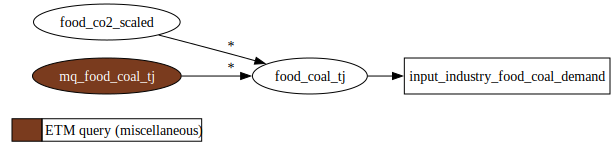

In [197]:
# Define ETLocal key
etlocal_key = "input_industry_food_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [198]:
# Generate commit message for food coal demand
message = generate_commit_message("Food")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [199]:
# Calculate values for input_industry_food_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_food_coal_demand  food_coal_tj error_message  \
GM0014                        12.393686     12.393686           NaN   
GM0034                         0.618962      0.618962           NaN   
GM0037                         0.119978      0.119978           NaN   
GM0047                         0.084097      0.084097           NaN   
GM0050                         0.251170      0.251170           NaN   
...                                 ...           ...           ...   
GM1979                         0.098674      0.098674           NaN   
GM1980                         0.738932      0.738932           NaN   
GM1982                         0.728839      0.728839           NaN   
GM1991                         0.849546      0.849546           NaN   
GM1992                         2.834481      2.834481           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [200]:
# Add data to template for input_industry_food_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [201]:
# Validate data for input_industry_food_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_food_coal_demand', 'total_rows': 342, 'zero_count': 3, 'nan_count': 0, 'min_value': 0.0, 'max_value': 18.440393636475452, 'mean_value': 0.8611842105263035, 'median_value': 0.1911805305533315}


6. Verify data

- *Action*: compare with verification dataset

In [202]:
# Verify data for input_industry_food_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_food_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  exact_match: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=18.44, Mean=0.86
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=18.44, Mean=0.86

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0715: Template=18.44, Verification=0.00, Diff=18.44 (0.0%)
  Municipality GM0599: Template=18.09, Verification=0.00, D

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Metal other

##### metal other electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

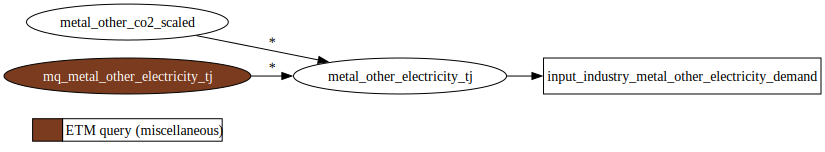

In [203]:
# Define ETLocal key
etlocal_key = "input_industry_metal_other_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [204]:
# Generate commit message for metal other electricity demand
message = generate_commit_message("Other metal")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [205]:
# Calculate values for input_industry_metal_other_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_other_electricity_demand  \
GM0014                                            0.0   
GM0034                                            0.0   
GM0037                                            0.0   
GM0047                                            0.0   
GM0050                                            0.0   
...                                               ...   
GM1979                                            0.0   
GM1980                                            0.0   
GM1982                                            0.0   
GM1991                                            0.0   
GM1992                                            0.0   

        metal_other_electricity_tj error_message  \
GM0014                         0.0           NaN   
GM0034                         0.0           NaN   
GM0037                         0.0           NaN   
GM0047                         0.0           NaN   
GM0050                         0.0           NaN   
...                            ...           ...   
GM1979                         0.0           NaN   
GM1980                         0.0           NaN   
GM1982                         0.0           NaN   
GM1991                         0.0           NaN   
GM1992                         0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [206]:
# Add data to template for input_industry_metal_other_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [207]:
# Validate data for input_industry_metal_other_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_other_electricity_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2782.69959328701, 'mean_value': 9.630678362573107, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [208]:
# Verify data for input_industry_metal_other_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_other_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 331 municipalities (97.9%)
  large_diff: 7 municipalities (2.1%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2782.70, Mean=9.74
  Verification: Min=0.00, Max=3170.19, Mean=9.72
  Abs diff:     Min=0.00, Max=387.49, Mean=2.33

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1706: Template=2782.70, Verification=3170.19, Diff=387.49 (-12.2%)
  Municipality GM0301: Template

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal other network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

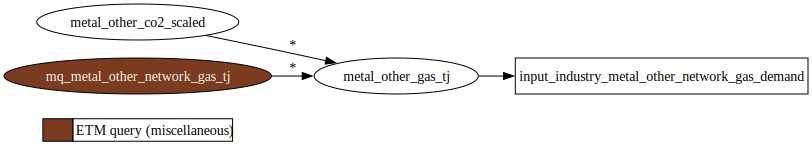

In [209]:
# Define ETLocal key
etlocal_key = "input_industry_metal_other_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [210]:
# Generate commit message for metal other network gas demand
message = generate_commit_message("Other metal")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [211]:
# Calculate values for input_industry_metal_other_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_other_network_gas_demand  metal_other_gas_tj  \
GM0014                                            0.0                 0.0   
GM0034                                            0.0                 0.0   
GM0037                                            0.0                 0.0   
GM0047                                            0.0                 0.0   
GM0050                                            0.0                 0.0   
...                                               ...                 ...   
GM1979                                            0.0                 0.0   
GM1980                                            0.0                 0.0   
GM1982                                            0.0                 0.0   
GM1991                                            0.0                 0.0   
GM1992                                            0.0                 0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [212]:
# Add data to template for input_industry_metal_other_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [213]:
# Validate data for input_industry_metal_other_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_other_network_gas_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 1150.2551337533355, 'mean_value': 3.9809317738791634, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [214]:
# Verify data for input_industry_metal_other_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_other_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  large_diff: 8 municipalities (2.4%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1150.26, Mean=4.03
  Verification: Min=0.00, Max=322.28, Mean=1.20
  Abs diff:     Min=0.00, Max=827.98, Mean=3.01

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1706: Template=1150.26, Verification=322.28, Diff=827.98 (256.9%)
  Municipality GM0301: Template=1

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal other steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

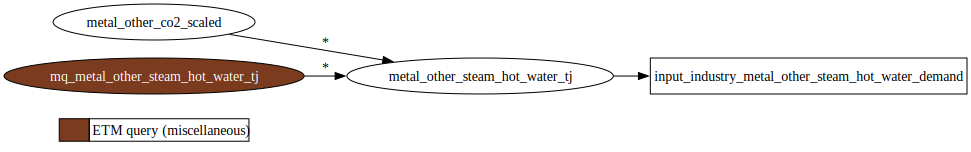

In [215]:
# Define ETLocal key
etlocal_key = "input_industry_metal_other_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [216]:
# Generate commit message for metal other steam hot water demand
message = generate_commit_message("Other metal")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [217]:
# Calculate values for input_industry_metal_other_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_other_steam_hot_water_demand  \
GM0014                                                0.0   
GM0034                                                0.0   
GM0037                                                0.0   
GM0047                                                0.0   
GM0050                                                0.0   
...                                                   ...   
GM1979                                                0.0   
GM1980                                                0.0   
GM1982                                                0.0   
GM1991                                                0.0   
GM1992                                                0.0   

        metal_other_steam_hot_water_tj error_message  \
GM0014                             0.0           NaN   
GM0034                             0.0           NaN   
GM0037                             0.0           NaN   
GM0047                             0.0           NaN   
GM0050                             0.0           NaN   
...                                ...           ...   
GM1979                             0.0           NaN   
GM1980                             0.0           NaN   
GM1982                             0.0           NaN   
GM1991                             0.0           NaN   
GM1992                             0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [218]:
# Add data to template for input_industry_metal_other_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [219]:
# Validate data for input_industry_metal_other_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_other_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 338, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0008448572583054443, 'mean_value': 2.923976607699123e-06, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [220]:
# Verify data for input_industry_metal_other_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_other_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 334 municipalities (98.8%)
  small_diff: 4 municipalities (1.2%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1706: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0301: Template=0.00, Verific

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal other crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

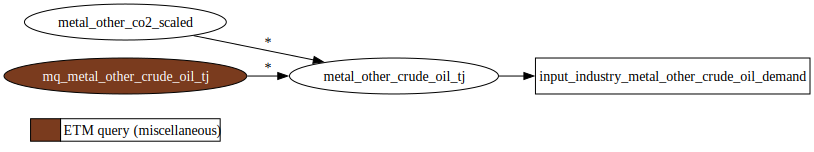

In [221]:
# Define ETLocal key
etlocal_key = "input_industry_metal_other_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [222]:
# Generate commit message for metal other crude oil demand
message = generate_commit_message("Other metal")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [223]:
# Calculate values for input_industry_metal_other_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_other_crude_oil_demand  metal_other_crude_oil_tj  \
GM0014                                          0.0                       0.0   
GM0034                                          0.0                       0.0   
GM0037                                          0.0                       0.0   
GM0047                                          0.0                       0.0   
GM0050                                          0.0                       0.0   
...                                             ...                       ...   
GM1979                                          0.0                       0.0   
GM1980                                          0.0                       0.0   
GM1982                                          0.0                       0.0   
GM1991                                          0.0                       0.0   
GM1992                                          0.0                       0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [224]:
# Add data to template for input_industry_metal_other_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [225]:
# Validate data for input_industry_metal_other_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_other_crude_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [226]:
# Verify data for input_industry_metal_other_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_other_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal other coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

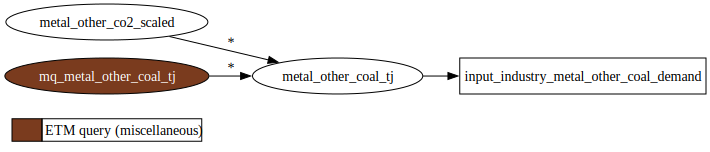

In [227]:
# Define ETLocal key
etlocal_key = "input_industry_metal_other_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [228]:
# Generate commit message for metal other coal demand
message = generate_commit_message("Other metal")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [229]:
# Calculate values for input_industry_metal_other_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_other_coal_demand  metal_other_coal_tj  \
GM0014                                     0.0                  0.0   
GM0034                                     0.0                  0.0   
GM0037                                     0.0                  0.0   
GM0047                                     0.0                  0.0   
GM0050                                     0.0                  0.0   
...                                        ...                  ...   
GM1979                                     0.0                  0.0   
GM1980                                     0.0                  0.0   
GM1982                                     0.0                  0.0   
GM1991                                     0.0                  0.0   
GM1992                                     0.0                  0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [230]:
# Add data to template for input_industry_metal_other_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [231]:
# Validate data for input_industry_metal_other_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_other_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [232]:
# Verify data for input_industry_metal_other_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_other_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM08

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Other industry

##### other electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

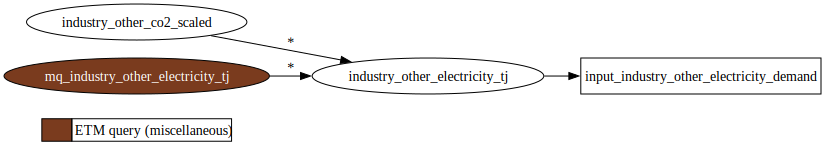

In [233]:
# Define ETLocal key
etlocal_key = "input_industry_other_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [234]:
# Generate commit message for other electricity demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [235]:
# Calculate values for input_industry_other_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_electricity_demand  \
GM0014                               146.970310   
GM0034                                90.101579   
GM0037                                49.550609   
GM0047                                57.535156   
GM0050                                13.663354   
...                                         ...   
GM1979                                74.547241   
GM1980                                95.254629   
GM1982                               414.935833   
GM1991                                93.785790   
GM1992                                53.474940   

        industry_other_electricity_tj error_message  \
GM0014                     146.970310           NaN   
GM0034                      90.101579           NaN   
GM0037                      49.550609           NaN   
GM0047                      57.535156           NaN   
GM0050                      13.663354           NaN   
...                               ...           ...   
GM1979                      74.547241           NaN   
GM1980                      95.254629           NaN   
GM1982                     414.935833           NaN   
GM1991                      93.785790           NaN   
GM1992                      53.474940           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [236]:
# Add data to template for input_industry_other_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [237]:
# Validate data for input_industry_other_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_electricity_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2202.8493726309493, 'mean_value': 111.84919590643084, 'median_value': 42.24933881624534}


6. Verify data

- *Action*: compare with verification dataset

In [238]:
# Verify data for input_industry_other_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 306 municipalities (90.5%)
  medium_diff: 30 municipalities (8.9%)
  small_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2202.85, Mean=111.23
  Verification: Min=1.12, Max=1956.11, Mean=123.01
  Abs diff:     Min=0.06, Max=1903.81, Mean=95.49

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0971: Template=52.30, Verification=1956.11, Diff=1903.81 (-

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

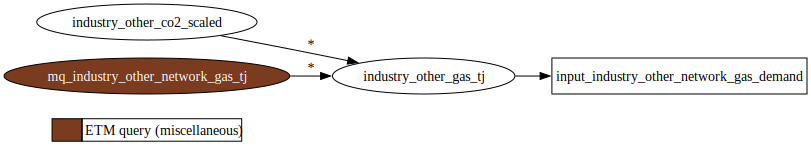

In [239]:
# Define ETLocal key
etlocal_key = "input_industry_other_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [240]:
# Generate commit message for other network gas demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [241]:
# Calculate values for input_industry_other_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_network_gas_demand  industry_other_gas_tj  \
GM0014                               195.577940             195.577940   
GM0034                               119.900960             119.900960   
GM0037                                65.938529              65.938529   
GM0047                                76.563813              76.563813   
GM0050                                18.182248              18.182248   
...                                         ...                    ...   
GM1979                                99.202321              99.202321   
GM1980                               126.758282             126.758282   
GM1982                               552.167955             552.167955   
GM1991                               124.803653             124.803653   
GM1992                                71.160758              71.160758   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [242]:
# Add data to template for input_industry_other_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [243]:
# Validate data for input_industry_other_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_network_gas_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2931.399836296869, 'mean_value': 148.8411866211507, 'median_value': 56.2225027404729}


6. Verify data

- *Action*: compare with verification dataset

In [244]:
# Verify data for input_industry_other_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 294 municipalities (87.0%)
  medium_diff: 38 municipalities (11.2%)
  small_diff: 6 municipalities (1.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2931.40, Mean=148.01
  Verification: Min=0.32, Max=3990.94, Mean=159.88
  Abs diff:     Min=0.03, Max=3572.33, Mean=86.58

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=418.61, Verification=3990.94, Diff=3572.33 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

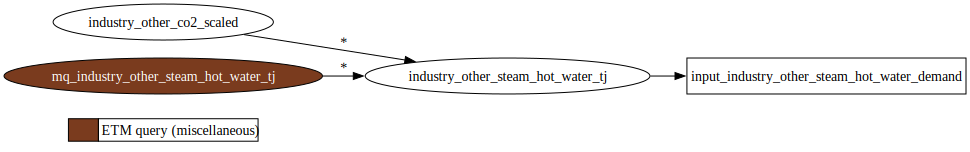

In [245]:
# Define ETLocal key
etlocal_key = "input_industry_other_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [246]:
# Generate commit message for other steam hot water demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [247]:
# Calculate values for input_industry_other_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_steam_hot_water_demand  \
GM0014                                    17.064774   
GM0034                                    10.461726   
GM0037                                     5.753339   
GM0047                                     6.680427   
GM0050                                     1.586457   
...                                             ...   
GM1979                                     8.655706   
GM1980                                    11.060048   
GM1982                                    48.178345   
GM1991                                    10.889501   
GM1992                                     6.208994   

        industry_other_steam_hot_water_tj error_message  \
GM0014                          17.064774           NaN   
GM0034                          10.461726           NaN   
GM0037                           5.753339           NaN   
GM0047                           6.680427           NaN   
GM0050                           1.586457           NaN   
...                                   ...           ...   
GM1979                           8.655706           NaN   
GM1980                          11.060048           NaN   
GM1982                          48.178345           NaN   
GM1991                          10.889501           NaN   
GM1992                           6.208994           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [248]:
# Add data to template for input_industry_other_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [249]:
# Validate data for input_industry_other_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 255.7736133570035, 'mean_value': 12.986849370411305, 'median_value': 4.9055855498957825}


6. Verify data

- *Action*: compare with verification dataset

In [250]:
# Verify data for input_industry_other_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=255.77, Mean=12.91
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=255.77, Mean=12.91

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=255.77, Verification=0.00, Diff=255.77 (0.0%)
  Municipality GM0957: Template=218.51, V

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

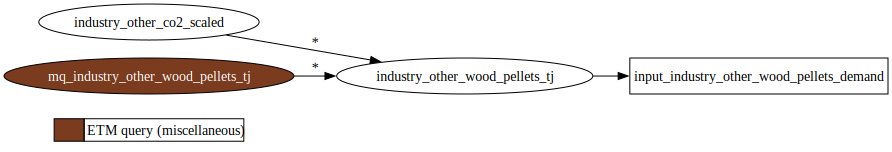

In [251]:
# Define ETLocal key
etlocal_key = "input_industry_other_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [252]:
# Generate commit message for other wood pellets demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [253]:
# Calculate values for input_industry_other_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_wood_pellets_demand  \
GM0014                                 11.694451   
GM0034                                  7.169397   
GM0037                                  3.942750   
GM0047                                  4.578082   
GM0050                                  1.087195   
...                                          ...   
GM1979                                  5.931736   
GM1980                                  7.579426   
GM1982                                 33.016510   
GM1991                                  7.462550   
GM1992                                  4.255010   

        industry_other_wood_pellets_tj error_message  \
GM0014                       11.694451           NaN   
GM0034                        7.169397           NaN   
GM0037                        3.942750           NaN   
GM0047                        4.578082           NaN   
GM0050                        1.087195           NaN   
...                                ...           ...   
GM1979                        5.931736           NaN   
GM1980                        7.579426           NaN   
GM1982                       33.016510           NaN   
GM1991                        7.462550           NaN   
GM1992                        4.255010           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [254]:
# Add data to template for input_industry_other_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [255]:
# Validate data for input_industry_other_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_wood_pellets_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 175.2810754564133, 'mean_value': 8.899858333935551, 'median_value': 3.3617866192045534}


6. Verify data

- *Action*: compare with verification dataset

In [256]:
# Verify data for input_industry_other_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=175.28, Mean=8.85
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=175.28, Mean=8.85

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=175.28, Verification=0.00, Diff=175.28 (0.0%)
  Municipality GM0957: Template=149.75, Verifi

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

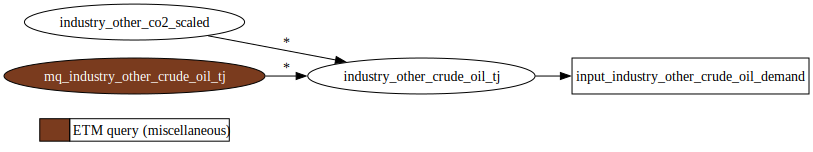

In [257]:
# Define ETLocal key
etlocal_key = "input_industry_other_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [258]:
# Generate commit message for other crude oil demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [259]:
# Calculate values for input_industry_other_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_crude_oil_demand  industry_other_crude_oil_tj  \
GM0014                               1.229677                     1.229677   
GM0034                               0.753865                     0.753865   
GM0037                               0.414582                     0.414582   
GM0047                               0.481387                     0.481387   
GM0050                               0.114319                     0.114319   
...                                       ...                          ...   
GM1979                               0.623725                     0.623725   
GM1980                               0.796980                     0.796980   
GM1982                               3.471700                     3.471700   
GM1991                               0.784690                     0.784690   
GM1992                               0.447416                     0.447416   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [260]:
# Add data to template for input_industry_other_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [261]:
# Validate data for input_industry_other_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_crude_oil_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 18.430880078525433, 'mean_value': 0.9358239116316969, 'median_value': 0.3534933013550466}


6. Verify data

- *Action*: compare with verification dataset

In [262]:
# Verify data for input_industry_other_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=18.43, Mean=0.93
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=18.43, Mean=0.93

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=18.43, Verification=0.00, Diff=18.43 (0.0%)
  Municipality GM0957: Template=15.75, Verification=0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

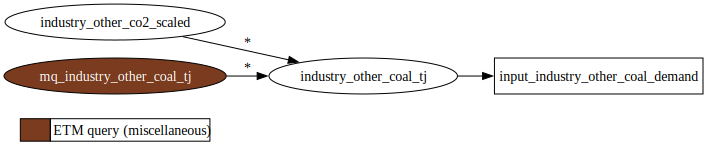

In [263]:
# Define ETLocal key
etlocal_key = "input_industry_other_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [264]:
# Generate commit message for other coal demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [265]:
# Calculate values for input_industry_other_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_coal_demand  industry_other_coal_tj  \
GM0014                          0.049721                0.049721   
GM0034                          0.030482                0.030482   
GM0037                          0.016763                0.016763   
GM0047                          0.019464                0.019464   
GM0050                          0.004622                0.004622   
...                                  ...                     ...   
GM1979                          0.025220                0.025220   
GM1980                          0.032225                0.032225   
GM1982                          0.140375                0.140375   
GM1991                          0.031728                0.031728   
GM1992                          0.018091                0.018091   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [266]:
# Add data to template for input_industry_other_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [267]:
# Validate data for input_industry_other_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_coal_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.7452357263942513, 'mean_value': 0.0378391812865484, 'median_value': 0.01429317732460155}


6. Verify data

- *Action*: compare with verification dataset

In [268]:
# Verify data for input_industry_other_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.75, Mean=0.04
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.75, Mean=0.04

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=0.75, Verification=0.00, Diff=0.75 (0.0%)
  Municipality GM0957: Template=0.64, Verification=0.00, Diff=

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other cokes demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

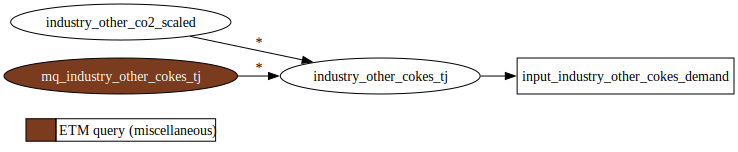

In [269]:
# Define ETLocal key
etlocal_key = "input_industry_other_cokes_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [270]:
# Generate commit message for other cokes demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [271]:
# Calculate values for input_industry_other_cokes_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_cokes_demand  industry_other_cokes_tj  \
GM0014                           2.772660                 2.772660   
GM0034                           1.699806                 1.699806   
GM0037                           0.934794                 0.934794   
GM0047                           1.085426                 1.085426   
GM0050                           0.257765                 0.257765   
...                                   ...                      ...   
GM1979                           1.406367                 1.406367   
GM1980                           1.797021                 1.797021   
GM1982                           7.827949                 7.827949   
GM1991                           1.769311                 1.769311   
GM1992                           1.008829                 1.008829   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [272]:
# Add data to template for input_industry_other_cokes_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [273]:
# Validate data for input_industry_other_cokes_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_cokes_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 41.55773253355176, 'mean_value': 2.110084795321597, 'median_value': 0.7970525556851511}


6. Verify data

- *Action*: compare with verification dataset

In [274]:
# Verify data for input_industry_other_cokes_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_cokes_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=41.56, Mean=2.10
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=41.56, Mean=2.10

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=41.56, Verification=0.00, Diff=41.56 (0.0%)
  Municipality GM0957: Template=35.50, Verification=0.00,

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other network gas non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

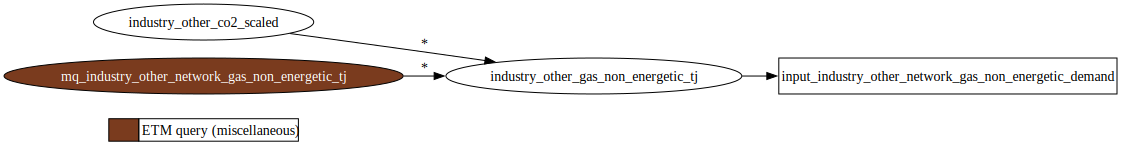

In [275]:
# Define ETLocal key
etlocal_key = "input_industry_other_network_gas_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [276]:
# Generate commit message for other network gas non energetic demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [277]:
# Calculate values for input_industry_other_network_gas_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_network_gas_non_energetic_demand  \
GM0014                                                0.0       
GM0034                                                0.0       
GM0037                                                0.0       
GM0047                                                0.0       
GM0050                                                0.0       
...                                                   ...       
GM1979                                                0.0       
GM1980                                                0.0       
GM1982                                                0.0       
GM1991                                                0.0       
GM1992                                                0.0       

        industry_other_gas_non_energetic_tj error_message  \
GM0014                                  0.0           NaN   
GM0034                                  0.0           NaN   
GM0037                                  0.0           NaN   
GM0047                                  0.0           NaN   
GM0050                                  0.0           NaN   
...                                     ...           ...   
GM1979                                  0.0           NaN   
GM1980                                  0.0           NaN   
GM1982                                  0.0           NaN   
GM1991                                  0.0           NaN   
GM1992                                  0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [278]:
# Add data to template for input_industry_other_network_gas_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [279]:
# Validate data for input_industry_other_network_gas_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_network_gas_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [280]:
# Verify data for input_industry_other_network_gas_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_network_gas_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Mu

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other wood pellets non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

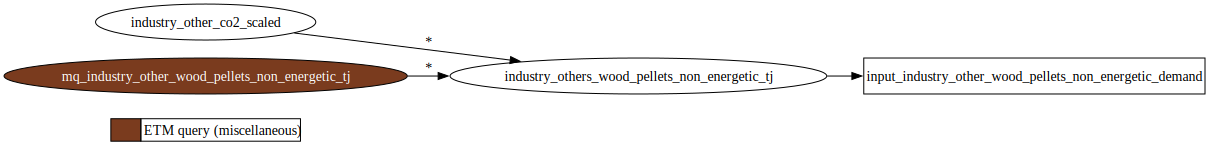

In [281]:
# Define ETLocal key
etlocal_key = "input_industry_other_wood_pellets_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [282]:
# Generate commit message for other wood pellets non energetic demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [283]:
# Calculate values for input_industry_other_wood_pellets_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_wood_pellets_non_energetic_demand  \
GM0014                                                0.0        
GM0034                                                0.0        
GM0037                                                0.0        
GM0047                                                0.0        
GM0050                                                0.0        
...                                                   ...        
GM1979                                                0.0        
GM1980                                                0.0        
GM1982                                                0.0        
GM1991                                                0.0        
GM1992                                                0.0        

        industry_others_wood_pellets_non_energetic_tj error_message  \
GM0014                                            0.0           NaN   
GM0034                                            0.0           NaN   
GM0037                                            0.0           NaN   
GM0047                                            0.0           NaN   
GM0050                                            0.0           NaN   
...                                               ...           ...   
GM1979                                            0.0           NaN   
GM1980                                            0.0           NaN   
GM1982                                            0.0           NaN   
GM1991                                            0.0           NaN   
GM1992                                            0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [284]:
# Add data to template for input_industry_other_wood_pellets_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [285]:
# Validate data for input_industry_other_wood_pellets_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_wood_pellets_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [286]:
# Verify data for input_industry_other_wood_pellets_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_wood_pellets_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  M

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other crude oil non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

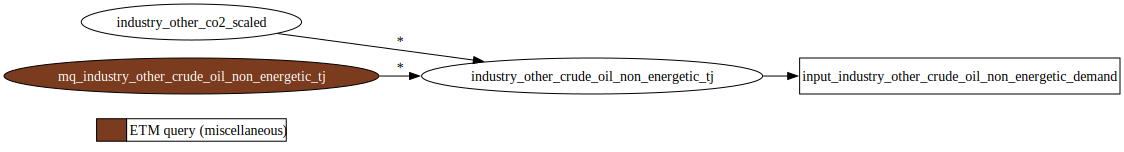

In [287]:
# Define ETLocal key
etlocal_key = "input_industry_other_crude_oil_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [288]:
# Generate commit message for other crude oil non energetic demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [289]:
# Calculate values for input_industry_other_crude_oil_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_crude_oil_non_energetic_demand  \
GM0014                                          40.482349     
GM0034                                          24.818098     
GM0037                                          13.648505     
GM0047                                          15.847815     
GM0050                                           3.763513     
...                                                   ...     
GM1979                                          20.533722     
GM1980                                          26.237484     
GM1982                                         114.292316     
GM1991                                          25.832898     
GM1992                                          14.729446     

        industry_other_crude_oil_non_energetic_tj error_message  \
GM0014                                  40.482349           NaN   
GM0034                                  24.818098           NaN   
GM0037                                  13.648505           NaN   
GM0047                                  15.847815           NaN   
GM0050                                   3.763513           NaN   
...                                           ...           ...   
GM1979                                  20.533722           NaN   
GM1980                                  26.237484           NaN   
GM1982                                 114.292316           NaN   
GM1991                                  25.832898           NaN   
GM1992                                  14.729446           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [290]:
# Add data to template for input_industry_other_crude_oil_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [291]:
# Validate data for input_industry_other_crude_oil_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_crude_oil_non_energetic_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 606.76552156966, 'mean_value': 30.808386871344403, 'median_value': 11.637401277326088}


6. Verify data

- *Action*: compare with verification dataset

In [292]:
# Verify data for input_industry_other_crude_oil_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_crude_oil_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=606.77, Mean=30.64
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=606.77, Mean=30.64

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=606.77, Verification=0.00, Diff=606.77 (0.0%)
  Municipality GM0957: Template=5

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other coal non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

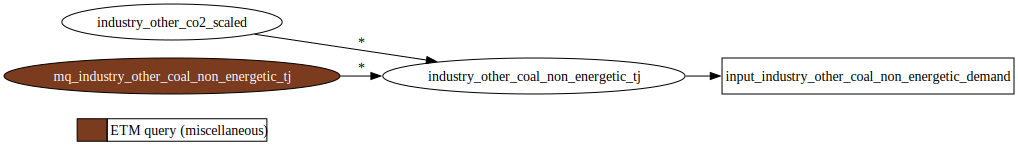

In [293]:
# Define ETLocal key
etlocal_key = "input_industry_other_coal_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [294]:
# Generate commit message for other coal non energetic demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [295]:
# Calculate values for input_industry_other_coal_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_coal_non_energetic_demand  \
GM0014                                        3.884876   
GM0034                                        2.381661   
GM0037                                        1.309775   
GM0047                                        1.520831   
GM0050                                        0.361164   
...                                                ...   
GM1979                                        1.970512   
GM1980                                        2.517872   
GM1982                                       10.968028   
GM1991                                        2.479046   
GM1992                                        1.413507   

        industry_other_coal_non_energetic_tj error_message  \
GM0014                              3.884876           NaN   
GM0034                              2.381661           NaN   
GM0037                              1.309775           NaN   
GM0047                              1.520831           NaN   
GM0050                              0.361164           NaN   
...                                      ...           ...   
GM1979                              1.970512           NaN   
GM1980                              2.517872           NaN   
GM1982                             10.968028           NaN   
GM1991                              2.479046           NaN   
GM1992                              1.413507           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [296]:
# Add data to template for input_industry_other_coal_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [297]:
# Validate data for input_industry_other_coal_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_coal_non_energetic_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 58.22807007134737, 'mean_value': 2.9565175438596, 'median_value': 1.1167796997950155}


6. Verify data

- *Action*: compare with verification dataset

In [298]:
# Verify data for input_industry_other_coal_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_coal_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=58.23, Mean=2.94
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=58.23, Mean=2.94

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=58.23, Verification=0.00, Diff=58.23 (0.0%)
  Municipality GM0957: Template=49.75, Verif

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### other cokes non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

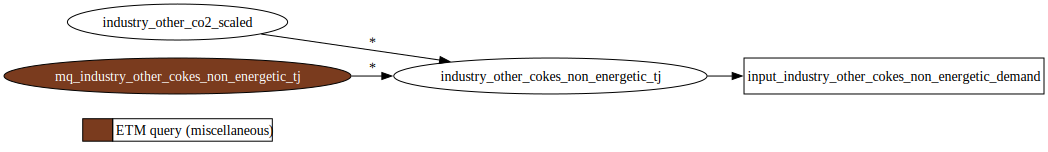

In [299]:
# Define ETLocal key
etlocal_key = "input_industry_other_cokes_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [300]:
# Generate commit message for other cokes non energetic demand
message = generate_commit_message("Other industry")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [301]:
# Calculate values for input_industry_other_cokes_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_other_cokes_non_energetic_demand  \
GM0014                                         0.965904   
GM0034                                         0.592157   
GM0037                                         0.325652   
GM0047                                         0.378127   
GM0050                                         0.089797   
...                                                 ...   
GM1979                                         0.489932   
GM1980                                         0.626024   
GM1982                                         2.727002   
GM1991                                         0.616370   
GM1992                                         0.351443   

        industry_other_cokes_non_energetic_tj error_message  \
GM0014                               0.965904           NaN   
GM0034                               0.592157           NaN   
GM0037                               0.325652           NaN   
GM0047                               0.378127           NaN   
GM0050                               0.089797           NaN   
...                                       ...           ...   
GM1979                               0.489932           NaN   
GM1980                               0.626024           NaN   
GM1982                               2.727002           NaN   
GM1991                               0.616370           NaN   
GM1992                               0.351443           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [302]:
# Add data to template for input_industry_other_cokes_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [303]:
# Validate data for input_industry_other_cokes_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_other_cokes_non_energetic_demand', 'total_rows': 342, 'zero_count': 2, 'nan_count': 0, 'min_value': 0.0, 'max_value': 14.477360047893647, 'mean_value': 0.735084795321625, 'median_value': 0.27766714212406834}


6. Verify data

- *Action*: compare with verification dataset

In [304]:
# Verify data for input_industry_other_cokes_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_other_cokes_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  exact_match: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=14.48, Mean=0.73
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=14.48, Mean=0.73

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0935: Template=14.48, Verification=0.00, Diff=14.48 (0.0%)
  Municipality GM0957: Template=12.37, Veri

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Paper

##### paper electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

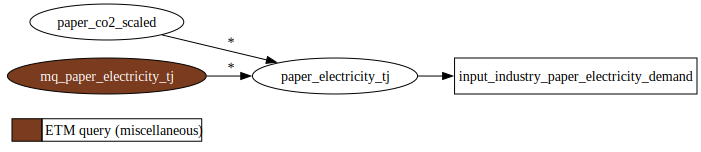

In [305]:
# Define ETLocal key
etlocal_key = "input_industry_paper_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [306]:
# Generate commit message for paper electricity demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [307]:
# Calculate values for input_industry_paper_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_electricity_demand  paper_electricity_tj  \
GM0014                                55.816667             55.816667   
GM0034                                 1.656864              1.656864   
GM0037                                 0.000000              0.000000   
GM0047                                 0.000000              0.000000   
GM0050                                 0.000000              0.000000   
...                                         ...                   ...   
GM1979                                 0.517770              0.517770   
GM1980                                 0.000000              0.000000   
GM1982                                74.789556             74.789556   
GM1991                                 0.931986              0.931986   
GM1992                                 0.880209              0.880209   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [308]:
# Add data to template for input_industry_paper_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [309]:
# Validate data for input_industry_paper_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_electricity_demand', 'total_rows': 342, 'zero_count': 204, 'nan_count': 0, 'min_value': 0.0, 'max_value': 1362.5118013679946, 'mean_value': 17.120777777777672, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [310]:
# Verify data for input_industry_paper_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 201 municipalities (59.5%)
  large_diff: 110 municipalities (32.5%)
  medium_diff: 14 municipalities (4.1%)
  small_diff: 13 municipalities (3.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1362.51, Mean=17.10
  Verification: Min=0.00, Max=4268.63, Mean=27.45
  Abs diff:     Min=0.00, Max=3993.03, Mean=19.51

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=275

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### paper network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

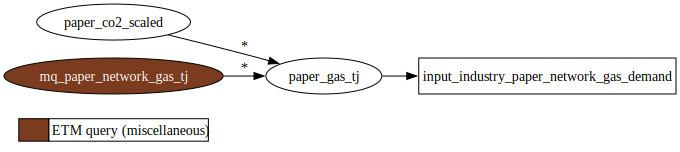

In [311]:
# Define ETLocal key
etlocal_key = "input_industry_paper_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [312]:
# Generate commit message for paper network gas demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [313]:
# Calculate values for input_industry_paper_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_network_gas_demand  paper_gas_tj error_message  \
GM0014                                97.024149     97.024149           NaN   
GM0034                                 2.880068      2.880068           NaN   
GM0037                                 0.000000      0.000000           NaN   
GM0047                                 0.000000      0.000000           NaN   
GM0050                                 0.000000      0.000000           NaN   
...                                         ...           ...           ...   
GM1979                                 0.900021      0.900021           NaN   
GM1980                                 0.000000      0.000000           NaN   
GM1982                               130.004056    130.004056           NaN   
GM1991                                 1.620038      1.620038           NaN   
GM1992                                 1.530036      1.530036           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [314]:
# Add data to template for input_industry_paper_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [315]:
# Validate data for input_industry_paper_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_network_gas_demand', 'total_rows': 342, 'zero_count': 204, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2368.4063606493487, 'mean_value': 29.760446072790366, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [316]:
# Verify data for input_industry_paper_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 201 municipalities (59.5%)
  large_diff: 111 municipalities (32.8%)
  medium_diff: 13 municipalities (3.8%)
  small_diff: 13 municipalities (3.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2368.41, Mean=29.72
  Verification: Min=0.00, Max=6489.12, Mean=63.19
  Abs diff:     Min=0.00, Max=6010.05, Mean=37.23

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=479

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### paper steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

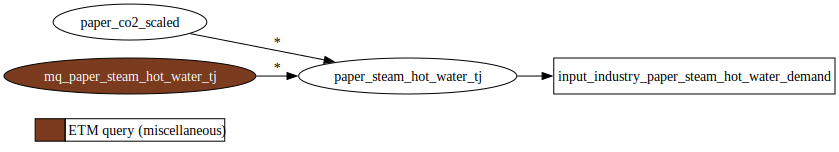

In [317]:
# Define ETLocal key
etlocal_key = "input_industry_paper_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [318]:
# Generate commit message for paper steam hot water demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [319]:
# Calculate values for input_industry_paper_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_steam_hot_water_demand  paper_steam_hot_water_tj  \
GM0014                                     8.297275                  8.297275   
GM0034                                     0.246297                  0.246297   
GM0037                                     0.000000                  0.000000   
GM0047                                     0.000000                  0.000000   
GM0050                                     0.000000                  0.000000   
...                                             ...                       ...   
GM1979                                     0.076968                  0.076968   
GM1980                                     0.000000                  0.000000   
GM1982                                    11.117639                 11.117639   
GM1991                                     0.138542                  0.138542   
GM1992                                     0.130845                  0.130845   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [320]:
# Add data to template for input_industry_paper_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [321]:
# Validate data for input_industry_paper_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 204, 'nan_count': 0, 'min_value': 0.0, 'max_value': 202.54049601108753, 'mean_value': 2.545042780345161, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [322]:
# Verify data for input_industry_paper_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 203 municipalities (60.1%)
  small_diff: 135 municipalities (39.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=202.54, Mean=2.54
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=202.54, Mean=2.54

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0274: Template=202.54, Verification=0.00, Diff=202.54 (0.0%)
  Municipality GM0957: Template=170.03, 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### paper wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

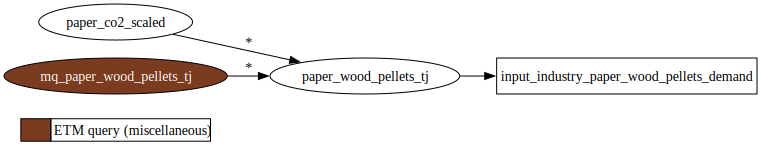

In [323]:
# Define ETLocal key
etlocal_key = "input_industry_paper_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [324]:
# Generate commit message for paper wood pellets demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [325]:
# Calculate values for input_industry_paper_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_wood_pellets_demand  paper_wood_pellets_tj  \
GM0014                                       0.0                    0.0   
GM0034                                       0.0                    0.0   
GM0037                                       0.0                    0.0   
GM0047                                       0.0                    0.0   
GM0050                                       0.0                    0.0   
...                                          ...                    ...   
GM1979                                       0.0                    0.0   
GM1980                                       0.0                    0.0   
GM1982                                       0.0                    0.0   
GM1991                                       0.0                    0.0   
GM1992                                       0.0                    0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [326]:
# Add data to template for input_industry_paper_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [327]:
# Validate data for input_industry_paper_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [328]:
# Verify data for input_industry_paper_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### paper crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

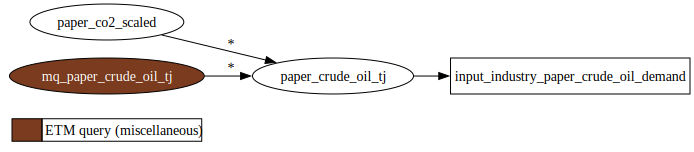

In [329]:
# Define ETLocal key
etlocal_key = "input_industry_paper_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [330]:
# Generate commit message for paper crude oil demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [331]:
# Calculate values for input_industry_paper_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_crude_oil_demand  paper_crude_oil_tj  \
GM0014                               0.001134            0.001134   
GM0034                               0.000034            0.000034   
GM0037                               0.000000            0.000000   
GM0047                               0.000000            0.000000   
GM0050                               0.000000            0.000000   
...                                       ...                 ...   
GM1979                               0.000011            0.000011   
GM1980                               0.000000            0.000000   
GM1982                               0.001520            0.001520   
GM1991                               0.000019            0.000019   
GM1992                               0.000018            0.000018   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [332]:
# Add data to template for input_industry_paper_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [333]:
# Validate data for input_industry_paper_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_crude_oil_demand', 'total_rows': 342, 'zero_count': 204, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.027690936112099704, 'mean_value': 0.0003479532163742727, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [334]:
# Verify data for input_industry_paper_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 203 municipalities (60.1%)
  small_diff: 135 municipalities (39.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.03, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.03, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0274: Template=0.03, Verification=0.00, Diff=0.03 (0.0%)
  Municipality GM0957: Template=0.02, Verification=0.0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### paper coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

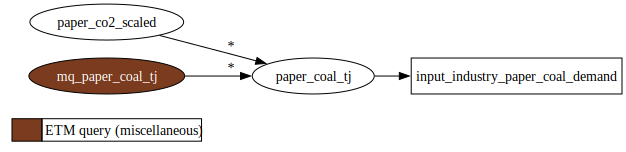

In [335]:
# Define ETLocal key
etlocal_key = "input_industry_paper_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [336]:
# Generate commit message for paper coal demand
message = generate_commit_message("Paper")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [337]:
# Calculate values for input_industry_paper_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_paper_coal_demand  paper_coal_tj error_message  \
GM0014                               0.0            0.0           NaN   
GM0034                               0.0            0.0           NaN   
GM0037                               0.0            0.0           NaN   
GM0047                               0.0            0.0           NaN   
GM0050                               0.0            0.0           NaN   
...                                  ...            ...           ...   
GM1979                               0.0            0.0           NaN   
GM1980                               0.0            0.0           NaN   
GM1982                               0.0            0.0           NaN   
GM1991                               0.0            0.0           NaN   
GM1992                               0.0            0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [338]:
# Add data to template for input_industry_paper_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [339]:
# Validate data for input_industry_paper_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_paper_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [340]:
# Verify data for input_industry_paper_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_paper_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0880: Te

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Refineries

##### useful demand for chemical refineries crude oil non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

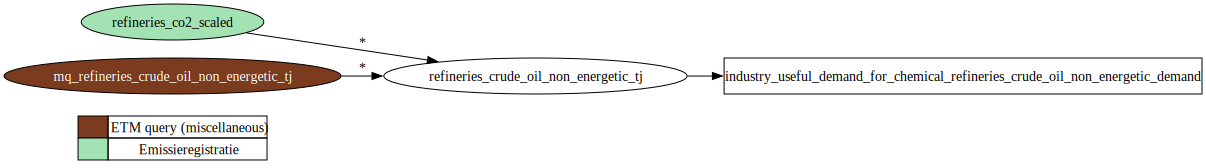

In [341]:
# Define ETLocal key
etlocal_key = "industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [342]:
# Generate commit message for useful demand for chemical refineries crude oil non energetic demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [343]:
# Calculate values for industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand  \
GM0014                                          17.307971                               
GM0034                                          16.223176                               
GM0037                                           2.265706                               
GM0047                                           2.016663                               
GM0050                                           1.708319                               
...                                                   ...                               
GM1979                                           3.272274                               
GM1980                                           6.482861                               
GM1982                                           6.616010                               
GM1991                                           4.283960                               
GM1992                                           5.367187                               

        refineries_crude_oil_non_energetic_tj error_message  \
GM0014                              17.307971           NaN   
GM0034                              16.223176           NaN   
GM0037                               2.265706           NaN   
GM0047                               2.016663           NaN   
GM0050                               1.708319           NaN   
...                                       ...           ...   
GM1979                               3.272274           NaN   
GM1980                               6.482861           NaN   
GM1982                               6.616010           NaN   
GM1991                               4.283960           NaN   
GM1992                               5.367187           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [344]:
# Add data to template for industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [345]:
# Validate data for industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.07175536670352128, 'max_value': 2276196.047464347, 'mean_value': 7726.362670387994, 'median_value': 2.358447532520268}


6. Verify data

- *Action*: compare with verification dataset

In [346]:
# Verify data for industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: industry_useful_demand_for_chemical_refineries_crude_oil_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  large_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.07, Max=2276196.05, Mean=7817.73
  Verification: Min=0.00, Max=2271884.14, Mean=7835.27
  Abs diff:     Min=0.07, Max=10200.93, Mean=57.37

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0654: Templat

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries wood pellets non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

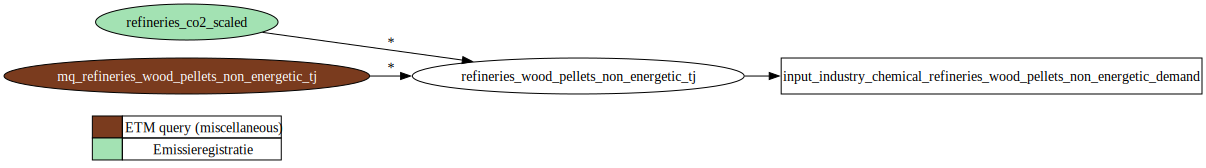

In [347]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_wood_pellets_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [348]:
# Generate commit message for chemical refineries wood pellets non energetic demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [349]:
# Calculate values for input_industry_chemical_refineries_wood_pellets_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_wood_pellets_non_energetic_demand  \
GM0014                                                0.0                      
GM0034                                                0.0                      
GM0037                                                0.0                      
GM0047                                                0.0                      
GM0050                                                0.0                      
...                                                   ...                      
GM1979                                                0.0                      
GM1980                                                0.0                      
GM1982                                                0.0                      
GM1991                                                0.0                      
GM1992                                                0.0                      

        refineries_wood_pellets_non_energetic_tj error_message  \
GM0014                                       0.0           NaN   
GM0034                                       0.0           NaN   
GM0037                                       0.0           NaN   
GM0047                                       0.0           NaN   
GM0050                                       0.0           NaN   
...                                          ...           ...   
GM1979                                       0.0           NaN   
GM1980                                       0.0           NaN   
GM1982                                       0.0           NaN   
GM1991                                       0.0           NaN   
GM1992                                       0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [350]:
# Add data to template for input_industry_chemical_refineries_wood_pellets_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [351]:
# Validate data for input_industry_chemical_refineries_wood_pellets_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_wood_pellets_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [352]:
# Verify data for input_industry_chemical_refineries_wood_pellets_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_wood_pellets_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries network gas non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

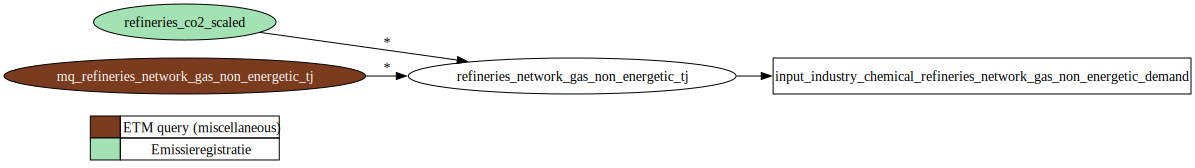

In [353]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_network_gas_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [354]:
# Generate commit message for chemical refineries network gas non energetic demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [355]:
# Calculate values for input_industry_chemical_refineries_network_gas_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_network_gas_non_energetic_demand  \
GM0014                                                0.0                     
GM0034                                                0.0                     
GM0037                                                0.0                     
GM0047                                                0.0                     
GM0050                                                0.0                     
...                                                   ...                     
GM1979                                                0.0                     
GM1980                                                0.0                     
GM1982                                                0.0                     
GM1991                                                0.0                     
GM1992                                                0.0                     

        refineries_network_gas_non_energetic_tj error_message  \
GM0014                                      0.0           NaN   
GM0034                                      0.0           NaN   
GM0037                                      0.0           NaN   
GM0047                                      0.0           NaN   
GM0050                                      0.0           NaN   
...                                         ...           ...   
GM1979                                      0.0           NaN   
GM1980                                      0.0           NaN   
GM1982                                      0.0           NaN   
GM1991                                      0.0           NaN   
GM1992                                      0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [356]:
# Add data to template for input_industry_chemical_refineries_network_gas_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [357]:
# Validate data for input_industry_chemical_refineries_network_gas_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_network_gas_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [358]:
# Verify data for input_industry_chemical_refineries_network_gas_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_network_gas_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries coal non energetic demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

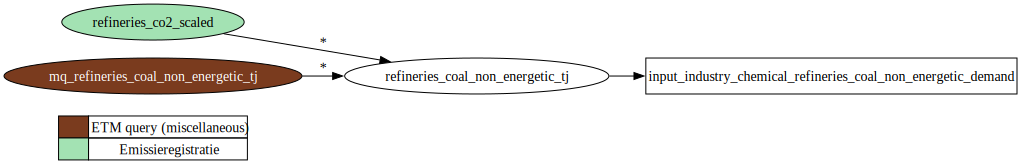

In [359]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_coal_non_energetic_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [360]:
# Generate commit message for chemical refineries coal non energetic demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [361]:
# Calculate values for input_industry_chemical_refineries_coal_non_energetic_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_coal_non_energetic_demand  \
GM0014                                                0.0              
GM0034                                                0.0              
GM0037                                                0.0              
GM0047                                                0.0              
GM0050                                                0.0              
...                                                   ...              
GM1979                                                0.0              
GM1980                                                0.0              
GM1982                                                0.0              
GM1991                                                0.0              
GM1992                                                0.0              

        refineries_coal_non_energetic_tj error_message  \
GM0014                               0.0           NaN   
GM0034                               0.0           NaN   
GM0037                               0.0           NaN   
GM0047                               0.0           NaN   
GM0050                               0.0           NaN   
...                                  ...           ...   
GM1979                               0.0           NaN   
GM1980                               0.0           NaN   
GM1982                               0.0           NaN   
GM1991                               0.0           NaN   
GM1992                               0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [362]:
# Add data to template for input_industry_chemical_refineries_coal_non_energetic_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [363]:
# Validate data for input_industry_chemical_refineries_coal_non_energetic_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_coal_non_energetic_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [364]:
# Verify data for input_industry_chemical_refineries_coal_non_energetic_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_coal_non_energetic_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

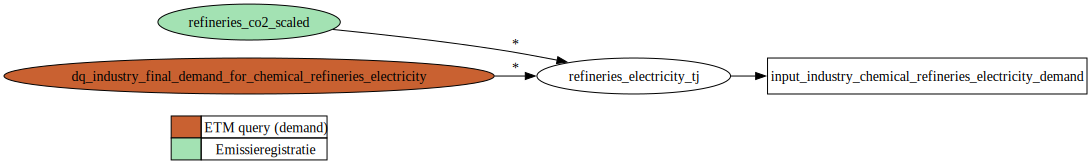

In [365]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [366]:
# Generate commit message for chemical refineries electricity demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [367]:
# Calculate values for input_industry_chemical_refineries_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_electricity_demand  \
GM0014                                           0.062708       
GM0034                                           0.058777       
GM0037                                           0.008209       
GM0047                                           0.007306       
GM0050                                           0.006189       
...                                                   ...       
GM1979                                           0.011856       
GM1980                                           0.023488       
GM1982                                           0.023970       
GM1991                                           0.015521       
GM1992                                           0.019446       

        refineries_electricity_tj error_message  \
GM0014                   0.062708           NaN   
GM0034                   0.058777           NaN   
GM0037                   0.008209           NaN   
GM0047                   0.007306           NaN   
GM0050                   0.006189           NaN   
...                           ...           ...   
GM1979                   0.011856           NaN   
GM1980                   0.023488           NaN   
GM1982                   0.023970           NaN   
GM1991                   0.015521           NaN   
GM1992                   0.019446           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [368]:
# Add data to template for input_industry_chemical_refineries_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [369]:
# Validate data for input_industry_chemical_refineries_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_electricity_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0002599732956303596, 'max_value': 8246.772543231467, 'mean_value': 27.992999812201937, 'median_value': 0.008544773802549532}


6. Verify data

- *Action*: compare with verification dataset

In [370]:
# Verify data for input_industry_chemical_refineries_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  medium_diff: 2 municipalities (0.6%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=8246.77, Mean=28.32
  Verification: Min=0.00, Max=8605.02, Mean=29.68
  Abs diff:     Min=0.00, Max=358.25, Mean=1.40

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=8246.77, Verification=8605.02, Diff

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

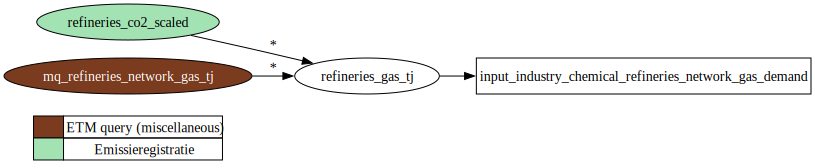

In [371]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [372]:
# Generate commit message for chemical refineries network gas demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [373]:
# Calculate values for input_industry_chemical_refineries_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_network_gas_demand  \
GM0014                                           0.112013       
GM0034                                           0.104993       
GM0037                                           0.014663       
GM0047                                           0.013051       
GM0050                                           0.011056       
...                                                   ...       
GM1979                                           0.021177       
GM1980                                           0.041956       
GM1982                                           0.042817       
GM1991                                           0.027725       
GM1992                                           0.034735       

        refineries_gas_tj error_message  \
GM0014           0.112013           NaN   
GM0034           0.104993           NaN   
GM0037           0.014663           NaN   
GM0047           0.013051           NaN   
GM0050           0.011056           NaN   
...                   ...           ...   
GM1979           0.021177           NaN   
GM1980           0.041956           NaN   
GM1982           0.042817           NaN   
GM1991           0.027725           NaN   
GM1992           0.034735           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [374]:
# Add data to template for input_industry_chemical_refineries_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [375]:
# Validate data for input_industry_chemical_refineries_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_network_gas_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.00046438461174296724, 'max_value': 14731.0294172148, 'mean_value': 50.003283290271426, 'median_value': 0.015263342548730047}


6. Verify data

- *Action*: compare with verification dataset

In [376]:
# Verify data for input_industry_chemical_refineries_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=14731.03, Mean=50.59
  Verification: Min=0.00, Max=34281.45, Mean=118.23
  Abs diff:     Min=0.00, Max=19550.42, Mean=67.73

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=14731.03, Verification=34281.45, Diff=19550.42 (-57.0%)
  Municipali

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

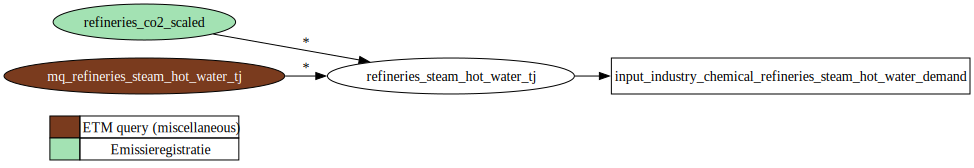

In [377]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [378]:
# Generate commit message for chemical refineries steam hot water demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [379]:
# Calculate values for input_industry_chemical_refineries_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_steam_hot_water_demand  \
GM0014                                           0.056962           
GM0034                                           0.053392           
GM0037                                           0.007457           
GM0047                                           0.006637           
GM0050                                           0.005622           
...                                                   ...           
GM1979                                           0.010769           
GM1980                                           0.021336           
GM1982                                           0.021774           
GM1991                                           0.014099           
GM1992                                           0.017664           

        refineries_steam_hot_water_tj error_message  \
GM0014                       0.056962           NaN   
GM0034                       0.053392           NaN   
GM0037                       0.007457           NaN   
GM0047                       0.006637           NaN   
GM0050                       0.005622           NaN   
...                               ...           ...   
GM1979                       0.010769           NaN   
GM1980                       0.021336           NaN   
GM1982                       0.021774           NaN   
GM1991                       0.014099           NaN   
GM1992                       0.017664           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [380]:
# Add data to template for input_industry_chemical_refineries_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [381]:
# Validate data for input_industry_chemical_refineries_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.00023615201092259816, 'max_value': 7491.122943928832, 'mean_value': 25.428008601339656, 'median_value': 0.007761818426227475}


6. Verify data

- *Action*: compare with verification dataset

In [382]:
# Verify data for input_industry_chemical_refineries_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=7491.12, Mean=25.73
  Verification: Min=0.00, Max=8837.50, Mean=30.48
  Abs diff:     Min=0.00, Max=1346.37, Mean=4.80

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=7491.12, Verification=8837.50, Diff=1346.37 (-15.2%)
  Municipality G

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

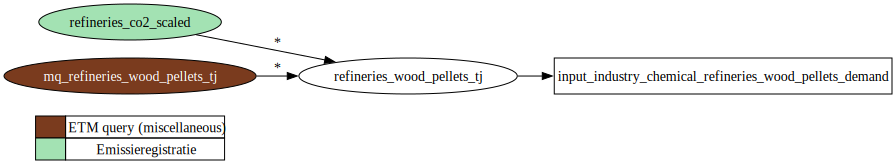

In [383]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [384]:
# Generate commit message for chemical refineries wood pellets demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [385]:
# Calculate values for input_industry_chemical_refineries_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_wood_pellets_demand  \
GM0014                                                0.0        
GM0034                                                0.0        
GM0037                                                0.0        
GM0047                                                0.0        
GM0050                                                0.0        
...                                                   ...        
GM1979                                                0.0        
GM1980                                                0.0        
GM1982                                                0.0        
GM1991                                                0.0        
GM1992                                                0.0        

        refineries_wood_pellets_tj error_message  \
GM0014                         0.0           NaN   
GM0034                         0.0           NaN   
GM0037                         0.0           NaN   
GM0047                         0.0           NaN   
GM0050                         0.0           NaN   
...                            ...           ...   
GM1979                         0.0           NaN   
GM1980                         0.0           NaN   
GM1982                         0.0           NaN   
GM1991                         0.0           NaN   
GM1992                         0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [386]:
# Add data to template for input_industry_chemical_refineries_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [387]:
# Validate data for input_industry_chemical_refineries_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [388]:
# Verify data for input_industry_chemical_refineries_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  M

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

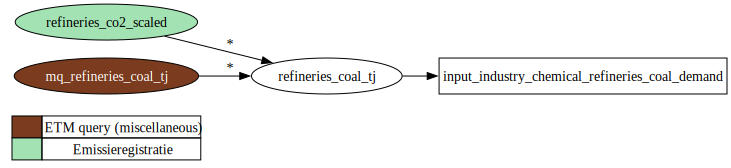

In [389]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [390]:
# Generate commit message for chemical refineries coal demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [391]:
# Calculate values for input_industry_chemical_refineries_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_coal_demand  refineries_coal_tj  \
GM0014                                             0.0                 0.0   
GM0034                                             0.0                 0.0   
GM0037                                             0.0                 0.0   
GM0047                                             0.0                 0.0   
GM0050                                             0.0                 0.0   
...                                                ...                 ...   
GM1979                                             0.0                 0.0   
GM1980                                             0.0                 0.0   
GM1982                                             0.0                 0.0   
GM1991                                             0.0                 0.0   
GM1992                                             0.0                 0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [392]:
# Add data to template for input_industry_chemical_refineries_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [393]:
# Validate data for input_industry_chemical_refineries_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_chemical_refineries_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [394]:
# Verify data for input_industry_chemical_refineries_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipal

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### chemical refineries crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

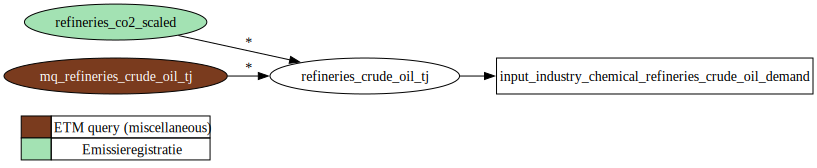

In [395]:
# Define ETLocal key
etlocal_key = "input_industry_chemical_refineries_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [396]:
# Generate commit message for chemical refineries crude oil demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [397]:
# Calculate values for input_industry_chemical_refineries_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_chemical_refineries_crude_oil_demand  \
GM0014                                           0.681393     
GM0034                                           0.638686     
GM0037                                           0.089198     
GM0047                                           0.079394     
GM0050                                           0.067254     
...                                                   ...     
GM1979                                           0.128825     
GM1980                                           0.255222     
GM1982                                           0.260464     
GM1991                                           0.168654     
GM1992                                           0.211299     

        refineries_crude_oil_tj error_message  \
GM0014                 0.681393           NaN   
GM0034                 0.638686           NaN   
GM0037                 0.089198           NaN   
GM0047                 0.079394           NaN   
GM0050                 0.067254           NaN   
...                         ...           ...   
GM1979                 0.128825           NaN   
GM1980                 0.255222           NaN   
GM1982                 0.260464           NaN   
GM1991                 0.168654           NaN   
GM1992                 0.211299           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [398]:
# Add data to template for input_industry_chemical_refineries_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [399]:
# Validate data for input_industry_chemical_refineries_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
# print(f"Validation results: {validation_results}")

6. Verify data

- *Action*: compare with verification dataset

In [400]:
# Verify data for input_industry_chemical_refineries_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
# print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_chemical_refineries_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  medium_diff: 2 municipalities (0.6%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=89611.01, Mean=307.77
  Verification: Min=0.00, Max=85827.84, Mean=296.00
  Abs diff:     Min=0.00, Max=3783.17, Mean=12.24

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=89611.01, Verification=85827.84

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


In [401]:
verification_results

template_value verification_value absolute_diff  relative_diff  \
GM0599    89611.010451        85827.84477   3783.165681       4.407854   
GM0654    14000.844721        13820.58644    180.258281       1.304274   
GM0363      320.631908         400.596708     79.964801     -19.961422   
GM1966       49.938223                  0     49.938223       0.000000   
GM0518        1.598453                  0      1.598453       0.000000   
...                ...                ...           ...            ...   
GM0093        0.014024                  0      0.014024       0.000000   
GM0060        0.010913                  0      0.010913       0.000000   
GM0277        0.005901                  0      0.005901       0.000000   
GM0096        0.003657                  0      0.003657       0.000000   
GM0088        0.002825                  0      0.002825       0.000000   

             status  
GM0599  medium_diff  
GM0654  medium_diff  
GM0363   large_diff  
GM1966   small_diff  
GM0518   small_diff  
...             ...  
GM0093   small_diff  
GM0060   small_diff  
GM0277   small_diff  
GM0096   small_diff  
GM0088   small_diff  

[338 rows x 5 columns]

##### refinery transformation crude oil other oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

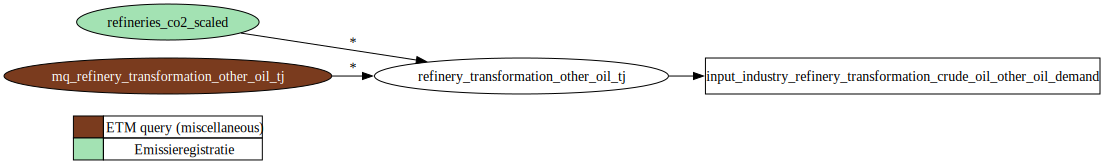

In [402]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_other_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [403]:
# Generate commit message for refinery transformation crude oil other oil demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [404]:
# Calculate values for input_industry_refinery_transformation_crude_oil_other_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_other_oil_demand  \
GM0014                                           1.013412                   
GM0034                                           0.949895                   
GM0037                                           0.132661                   
GM0047                                           0.118079                   
GM0050                                           0.100025                   
...                                                   ...                   
GM1979                                           0.191597                   
GM1980                                           0.379583                   
GM1982                                           0.387379                   
GM1991                                           0.250833                   
GM1992                                           0.314258                   

        refinery_transformation_other_oil_tj error_message  \
GM0014                              1.013412           NaN   
GM0034                              0.949895           NaN   
GM0037                              0.132661           NaN   
GM0047                              0.118079           NaN   
GM0050                              0.100025           NaN   
...                                      ...           ...   
GM1979                              0.191597           NaN   
GM1980                              0.379583           NaN   
GM1982                              0.387379           NaN   
GM1991                              0.250833           NaN   
GM1992                              0.314258           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [405]:
# Add data to template for input_industry_refinery_transformation_crude_oil_other_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [406]:
# Validate data for input_industry_refinery_transformation_crude_oil_other_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_other_oil_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0042014027807927585, 'max_value': 133275.27741526955, 'mean_value': 452.3921080761266, 'median_value': 0.13809124636524525}


6. Verify data

- *Action*: compare with verification dataset

In [407]:
# Verify data for input_industry_refinery_transformation_crude_oil_other_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_other_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=133275.28, Mean=457.74
  Verification: Min=0.00, Max=561379.27, Mean=1936.08
  Abs diff:     Min=0.00, Max=428103.99, Mean=1479.18

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=133275.28, Verification=561379.27, Diff=428103.99

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil gasoline demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

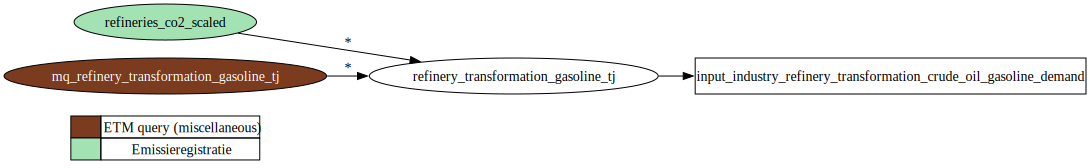

In [408]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_gasoline_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [409]:
# Generate commit message for refinery transformation crude oil gasoline demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [410]:
# Calculate values for input_industry_refinery_transformation_crude_oil_gasoline_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_gasoline_demand  \
GM0014                                           1.294168                  
GM0034                                           1.213055                  
GM0037                                           0.169414                  
GM0047                                           0.150792                  
GM0050                                           0.127736                  
...                                                   ...                  
GM1979                                           0.244678                  
GM1980                                           0.484743                  
GM1982                                           0.494699                  
GM1991                                           0.320324                  
GM1992                                           0.401320                  

        refinery_transformation_gasoline_tj error_message  \
GM0014                             1.294168           NaN   
GM0034                             1.213055           NaN   
GM0037                             0.169414           NaN   
GM0047                             0.150792           NaN   
GM0050                             0.127736           NaN   
...                                     ...           ...   
GM1979                             0.244678           NaN   
GM1980                             0.484743           NaN   
GM1982                             0.494699           NaN   
GM1991                             0.320324           NaN   
GM1992                             0.401320           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [411]:
# Add data to template for input_industry_refinery_transformation_crude_oil_gasoline_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [412]:
# Validate data for input_industry_refinery_transformation_crude_oil_gasoline_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_gasoline_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.005365359950883053, 'max_value': 170197.8775174205, 'mean_value': 577.7228762411617, 'median_value': 0.17634806312852735}


6. Verify data

- *Action*: compare with verification dataset

In [413]:
# Verify data for input_industry_refinery_transformation_crude_oil_gasoline_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_gasoline_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 2 municipalities (0.6%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.01, Max=170197.88, Mean=584.55
  Verification: Min=0.00, Max=150148.12, Mean=517.83
  Abs diff:     Min=0.01, Max=20049.76, Mean=67.27

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=170197.88, Veri

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil heavy fuel oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

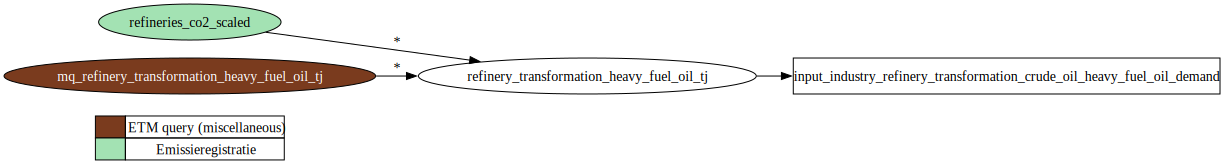

In [414]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [415]:
# Generate commit message for refinery transformation crude oil heavy fuel oil demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [416]:
# Calculate values for input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand  \
GM0014                                           2.575089                        
GM0034                                           2.413693                        
GM0037                                           0.337093                        
GM0047                                           0.300040                        
GM0050                                           0.254165                        
...                                                   ...                        
GM1979                                           0.486851                        
GM1980                                           0.964523                        
GM1982                                           0.984333                        
GM1991                                           0.637370                        
GM1992                                           0.798533                        

        refinery_transformation_heavy_fuel_oil_tj error_message  \
GM0014                                   2.575089           NaN   
GM0034                                   2.413693           NaN   
GM0037                                   0.337093           NaN   
GM0047                                   0.300040           NaN   
GM0050                                   0.254165           NaN   
...                                           ...           ...   
GM1979                                   0.486851           NaN   
GM1980                                   0.964523           NaN   
GM1982                                   0.984333           NaN   
GM1991                                   0.637370           NaN   
GM1992                                   0.798533           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [417]:
# Add data to template for input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [418]:
# Validate data for input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.010675800658949039, 'max_value': 338653.6280111377, 'mean_value': 1149.5322437500631, 'median_value': 0.3508910466001566}


6. Verify data

- *Action*: compare with verification dataset

In [419]:
# Verify data for input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_heavy_fuel_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  medium_diff: 2 municipalities (0.6%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.01, Max=338653.63, Mean=1163.13
  Verification: Min=0.00, Max=313045.75, Mean=1079.63
  Abs diff:     Min=0.01, Max=25607.88, Mean=84.97

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=338653.

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil kerosene demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

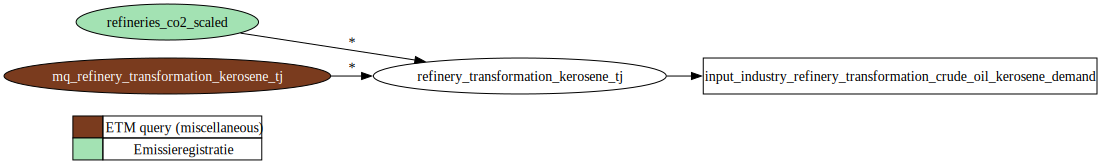

In [420]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_kerosene_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [421]:
# Generate commit message for refinery transformation crude oil kerosene demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [422]:
# Calculate values for input_industry_refinery_transformation_crude_oil_kerosene_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_kerosene_demand  \
GM0014                                           2.377938                  
GM0034                                           2.228899                  
GM0037                                           0.311285                  
GM0047                                           0.277069                  
GM0050                                           0.234706                  
...                                                   ...                  
GM1979                                           0.449577                  
GM1980                                           0.890679                  
GM1982                                           0.908972                  
GM1991                                           0.588572                  
GM1992                                           0.737397                  

        refinery_transformation_kerosene_tj error_message  \
GM0014                             2.377938           NaN   
GM0034                             2.228899           NaN   
GM0037                             0.311285           NaN   
GM0047                             0.277069           NaN   
GM0050                             0.234706           NaN   
...                                     ...           ...   
GM1979                             0.449577           NaN   
GM1980                             0.890679           NaN   
GM1982                             0.908972           NaN   
GM1991                             0.588572           NaN   
GM1992                             0.737397           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [423]:
# Add data to template for input_industry_refinery_transformation_crude_oil_kerosene_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [424]:
# Validate data for input_industry_refinery_transformation_crude_oil_kerosene_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_kerosene_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.009858454590618827, 'max_value': 312726.09149905056, 'mean_value': 1061.5233262118431, 'median_value': 0.32402660556073903}


6. Verify data

- *Action*: compare with verification dataset

In [425]:
# Verify data for input_industry_refinery_transformation_crude_oil_kerosene_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_kerosene_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 2 municipalities (0.6%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.01, Max=312726.09, Mean=1074.08
  Verification: Min=0.00, Max=337780.99, Mean=1164.94
  Abs diff:     Min=0.01, Max=25054.90, Mean=92.83

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=312726.09, Ve

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil LPG demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

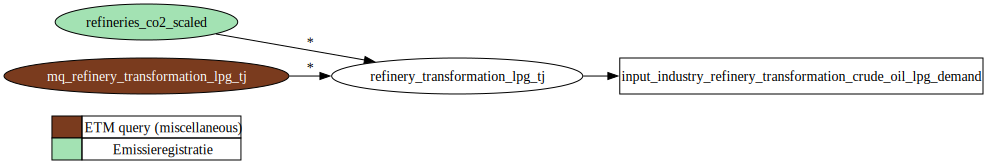

In [426]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_lpg_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [427]:
# Generate commit message for refinery transformation crude oil lpg demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [428]:
# Calculate values for input_industry_refinery_transformation_crude_oil_lpg_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_lpg_demand  \
GM0014                                           0.381325             
GM0034                                           0.357425             
GM0037                                           0.049917             
GM0047                                           0.044431             
GM0050                                           0.037637             
...                                                   ...             
GM1979                                           0.072094             
GM1980                                           0.142829             
GM1982                                           0.145762             
GM1991                                           0.094383             
GM1992                                           0.118248             

        refinery_transformation_lpg_tj error_message  \
GM0014                        0.381325           NaN   
GM0034                        0.357425           NaN   
GM0037                        0.049917           NaN   
GM0047                        0.044431           NaN   
GM0050                        0.037637           NaN   
...                                ...           ...   
GM1979                        0.072094           NaN   
GM1980                        0.142829           NaN   
GM1982                        0.145762           NaN   
GM1991                        0.094383           NaN   
GM1992                        0.118248           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [429]:
# Add data to template for input_industry_refinery_transformation_crude_oil_lpg_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [430]:
# Validate data for input_industry_refinery_transformation_crude_oil_lpg_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_lpg_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0015808958161489168, 'max_value': 50148.566908438646, 'mean_value': 170.2252386240839, 'median_value': 0.051960710509267864}


6. Verify data

- *Action*: compare with verification dataset

In [431]:
# Verify data for input_industry_refinery_transformation_crude_oil_lpg_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_lpg_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  large_diff: 3 municipalities (0.9%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=50148.57, Mean=172.24
  Verification: Min=0.00, Max=60644.74, Mean=209.15
  Abs diff:     Min=0.00, Max=10496.18, Mean=37.23

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=50148.57, Verification=60644.74, Diff=10496.18 (-17.3%)
  Mun

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil refinery gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

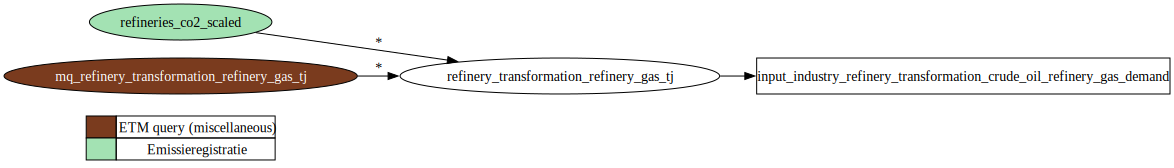

In [432]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_refinery_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [433]:
# Generate commit message for refinery transformation crude oil refinery gas demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [434]:
# Calculate values for input_industry_refinery_transformation_crude_oil_refinery_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_refinery_gas_demand  \
GM0014                                           0.700567                      
GM0034                                           0.656659                      
GM0037                                           0.091708                      
GM0047                                           0.081628                      
GM0050                                           0.069147                      
...                                                   ...                      
GM1979                                           0.132450                      
GM1980                                           0.262404                      
GM1982                                           0.267793                      
GM1991                                           0.173400                      
GM1992                                           0.217245                      

        refinery_transformation_refinery_gas_tj error_message  \
GM0014                                 0.700567           NaN   
GM0034                                 0.656659           NaN   
GM0037                                 0.091708           NaN   
GM0047                                 0.081628           NaN   
GM0050                                 0.069147           NaN   
...                                         ...           ...   
GM1979                                 0.132450           NaN   
GM1980                                 0.262404           NaN   
GM1982                                 0.267793           NaN   
GM1991                                 0.173400           NaN   
GM1992                                 0.217245           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [435]:
# Add data to template for input_industry_refinery_transformation_crude_oil_refinery_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [436]:
# Validate data for input_industry_refinery_transformation_crude_oil_refinery_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_refinery_gas_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0029044114149676423, 'max_value': 92132.61790264468, 'mean_value': 312.73669088438413, 'median_value': 0.0954618762295028}


6. Verify data

- *Action*: compare with verification dataset

In [437]:
# Verify data for input_industry_refinery_transformation_crude_oil_refinery_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_refinery_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 336 municipalities (99.4%)
  large_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=92132.62, Mean=316.43
  Verification: Min=0.00, Max=88781.24, Mean=306.19
  Abs diff:     Min=0.00, Max=3351.38, Mean=10.75

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=92132.62, Veri

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### refinery transformation crude oil diesel demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

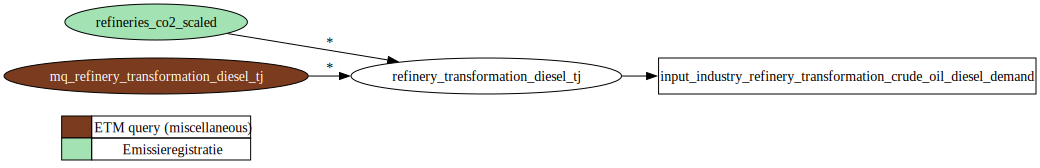

In [438]:
# Define ETLocal key
etlocal_key = "input_industry_refinery_transformation_crude_oil_diesel_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [439]:
# Generate commit message for refinery transformation crude oil diesel demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [440]:
# Calculate values for input_industry_refinery_transformation_crude_oil_diesel_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_refinery_transformation_crude_oil_diesel_demand  \
GM0014                                           5.598335                
GM0034                                           5.247454                
GM0037                                           0.732852                
GM0047                                           0.652298                
GM0050                                           0.552563                
...                                                   ...                
GM1979                                           1.058431                
GM1980                                           2.096908                
GM1982                                           2.139976                
GM1991                                           1.385665                
GM1992                                           1.736039                

        refinery_transformation_diesel_tj error_message  \
GM0014                           5.598335           NaN   
GM0034                           5.247454           NaN   
GM0037                           0.732852           NaN   
GM0047                           0.652298           NaN   
GM0050                           0.552563           NaN   
...                                   ...           ...   
GM1979                           1.058431           NaN   
GM1980                           2.096908           NaN   
GM1982                           2.139976           NaN   
GM1991                           1.385665           NaN   
GM1992                           1.736039           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [441]:
# Add data to template for input_industry_refinery_transformation_crude_oil_diesel_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [442]:
# Validate data for input_industry_refinery_transformation_crude_oil_diesel_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_diesel_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0232095724016994, 'max_value': 736245.0976296556, 'mean_value': 2499.1242054562254, 'median_value': 0.7628496832551515}


6. Verify data

- *Action*: compare with verification dataset

In [443]:
# Verify data for input_industry_refinery_transformation_crude_oil_diesel_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_refinery_transformation_crude_oil_diesel_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 335 municipalities (99.1%)
  medium_diff: 2 municipalities (0.6%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.02, Max=736245.10, Mean=2528.68
  Verification: Min=0.00, Max=760528.93, Mean=2622.91
  Abs diff:     Min=0.02, Max=24283.83, Mean=98.86

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=736245.10, Veri

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### distribution crude oil loss demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

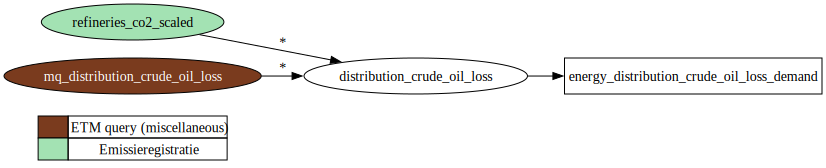

In [444]:
# Define ETLocal key
etlocal_key = "energy_distribution_crude_oil_loss_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [445]:
# Generate commit message for distribution crude oil loss demand
message = generate_commit_message("Refineries")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [446]:
# Calculate values for energy_distribution_crude_oil_loss_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

energy_distribution_crude_oil_loss_demand  \
GM0014                                   0.196010   
GM0034                                   0.183725   
GM0037                                   0.025659   
GM0047                                   0.022838   
GM0050                                   0.019346   
...                                           ...   
GM1979                                   0.037058   
GM1980                                   0.073417   
GM1982                                   0.074925   
GM1991                                   0.048515   
GM1992                                   0.060783   

        distribution_crude_oil_loss error_message  \
GM0014                     0.196010           NaN   
GM0034                     0.183725           NaN   
GM0037                     0.025659           NaN   
GM0047                     0.022838           NaN   
GM0050                     0.019346           NaN   
...                             ...           ...   
GM1979                     0.037058           NaN   
GM1980                     0.073417           NaN   
GM1982                     0.074925           NaN   
GM1991                     0.048515           NaN   
GM1992                     0.060783           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [447]:
# Add data to template for energy_distribution_crude_oil_loss_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [448]:
# Validate data for energy_distribution_crude_oil_loss_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'energy_distribution_crude_oil_loss_demand', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 0.0008126189434248963, 'max_value': 25777.58448034846, 'mean_value': 87.49991754163999, 'median_value': 0.026709070415852583}


6. Verify data

- *Action*: compare with verification dataset

In [449]:
# Verify data for energy_distribution_crude_oil_loss_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: energy_distribution_crude_oil_loss_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=25777.58, Mean=88.53
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=25777.58, Mean=88.53

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=25777.58, Verification=0.00, Diff=25777.58 (0.0%)
  Municipality GM0654: Template=4027.50, Verification=0.00, Diff=4027.50 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Steel

##### metal steel production

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

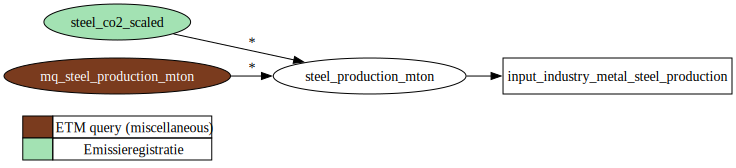

In [450]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_production"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [451]:
# Generate commit message for metal steel production
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [452]:
# Calculate values for input_industry_metal_steel_production
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_production  steel_production_mton  \
GM0014                                    0.0                    0.0   
GM0034                                    0.0                    0.0   
GM0037                                    0.0                    0.0   
GM0047                                    0.0                    0.0   
GM0050                                    0.0                    0.0   
...                                       ...                    ...   
GM1979                                    0.0                    0.0   
GM1980                                    0.0                    0.0   
GM1982                                    0.0                    0.0   
GM1991                                    0.0                    0.0   
GM1992                                    0.0                    0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [453]:
# Add data to template for input_industry_metal_steel_production
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [454]:
# Validate data for input_industry_metal_steel_production
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_production', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 4.679315784810418, 'mean_value': 0.013742690058479558, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [455]:
# Verify data for input_industry_metal_steel_production
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=4.68, Mean=0.01
  Verification: Min=0.00, Max=6.63, Mean=0.02
  Abs diff:     Min=0.00, Max=1.95, Mean=0.01

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=4.68, Verification=6.63, Diff=1.95 (-29.4%)
  Municipality GM

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel coal demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

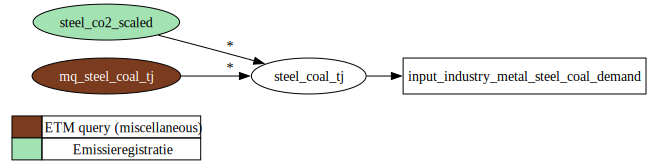

In [456]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_coal_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [457]:
# Generate commit message for metal steel coal demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [458]:
# Calculate values for input_industry_metal_steel_coal_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_coal_demand  steel_coal_tj error_message  \
GM0014                                     0.0            0.0           NaN   
GM0034                                     0.0            0.0           NaN   
GM0037                                     0.0            0.0           NaN   
GM0047                                     0.0            0.0           NaN   
GM0050                                     0.0            0.0           NaN   
...                                        ...            ...           ...   
GM1979                                     0.0            0.0           NaN   
GM1980                                     0.0            0.0           NaN   
GM1982                                     0.0            0.0           NaN   
GM1991                                     0.0            0.0           NaN   
GM1992                                     0.0            0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [459]:
# Add data to template for input_industry_metal_steel_coal_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [460]:
# Validate data for input_industry_metal_steel_coal_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_coal_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 34.23467076095544, 'mean_value': 0.10054385964912271, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [461]:
# Verify data for input_industry_metal_steel_coal_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_coal_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 8 municipalities (2.4%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=34.23, Mean=0.10
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=34.23, Mean=0.10

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=34.23, Verification=0.00, Diff=34.23 (0.0%)
  Municipality GM0482: Template=0.12, Verification=0

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel cokes demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

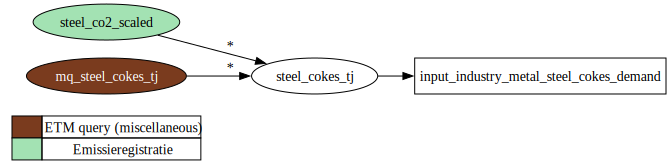

In [462]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_cokes_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [463]:
# Generate commit message for metal steel cokes demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [464]:
# Calculate values for input_industry_metal_steel_cokes_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_cokes_demand  steel_cokes_tj error_message  \
GM0014                                      0.0             0.0           NaN   
GM0034                                      0.0             0.0           NaN   
GM0037                                      0.0             0.0           NaN   
GM0047                                      0.0             0.0           NaN   
GM0050                                      0.0             0.0           NaN   
...                                         ...             ...           ...   
GM1979                                      0.0             0.0           NaN   
GM1980                                      0.0             0.0           NaN   
GM1982                                      0.0             0.0           NaN   
GM1991                                      0.0             0.0           NaN   
GM1992                                      0.0             0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [465]:
# Add data to template for input_industry_metal_steel_cokes_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [466]:
# Validate data for input_industry_metal_steel_cokes_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_cokes_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2917.8142387943135, 'mean_value': 8.569333333333326, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [467]:
# Verify data for input_industry_metal_steel_cokes_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_cokes_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2917.81, Mean=8.67
  Verification: Min=0.00, Max=39.16, Mean=0.12
  Abs diff:     Min=0.00, Max=2878.66, Mean=8.55

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=2917.81, Verification=39.16, Diff=2878.66 (7351.6%)


/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel coal gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

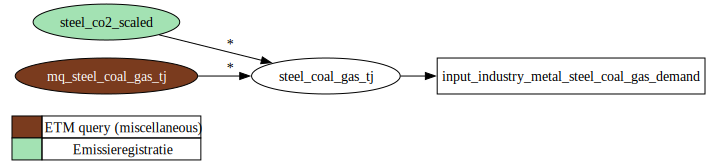

In [468]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_coal_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [469]:
# Generate commit message for metal steel coal gas demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [470]:
# Calculate values for input_industry_metal_steel_coal_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_coal_gas_demand  steel_coal_gas_tj  \
GM0014                                         0.0                0.0   
GM0034                                         0.0                0.0   
GM0037                                         0.0                0.0   
GM0047                                         0.0                0.0   
GM0050                                         0.0                0.0   
...                                            ...                ...   
GM1979                                         0.0                0.0   
GM1980                                         0.0                0.0   
GM1982                                         0.0                0.0   
GM1991                                         0.0                0.0   
GM1992                                         0.0                0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [471]:
# Add data to template for input_industry_metal_steel_coal_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [472]:
# Validate data for input_industry_metal_steel_coal_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_coal_gas_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 23872.22042198788, 'mean_value': 70.11036257309938, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [473]:
# Verify data for input_industry_metal_steel_coal_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_coal_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=23872.22, Mean=70.94
  Verification: Min=0.00, Max=26951.84, Mean=79.98
  Abs diff:     Min=0.00, Max=3079.62, Mean=9.18

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=2387

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel electricity demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

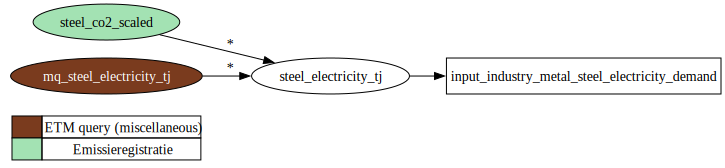

In [474]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_electricity_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [475]:
# Generate commit message for metal steel electricity demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [476]:
# Calculate values for input_industry_metal_steel_electricity_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_electricity_demand  steel_electricity_tj  \
GM0014                                            0.0                   0.0   
GM0034                                            0.0                   0.0   
GM0037                                            0.0                   0.0   
GM0047                                            0.0                   0.0   
GM0050                                            0.0                   0.0   
...                                               ...                   ...   
GM1979                                            0.0                   0.0   
GM1980                                            0.0                   0.0   
GM1982                                            0.0                   0.0   
GM1991                                            0.0                   0.0   
GM1992                                            0.0                   0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [477]:
# Add data to template for input_industry_metal_steel_electricity_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [478]:
# Validate data for input_industry_metal_steel_electricity_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_electricity_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 7526.751123002964, 'mean_value': 22.105327485380094, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [479]:
# Verify data for input_industry_metal_steel_electricity_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=7526.75, Mean=22.37
  Verification: Min=0.00, Max=9149.80, Mean=27.15
  Abs diff:     Min=0.00, Max=1623.05, Mean=4.83

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=752

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel network gas demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

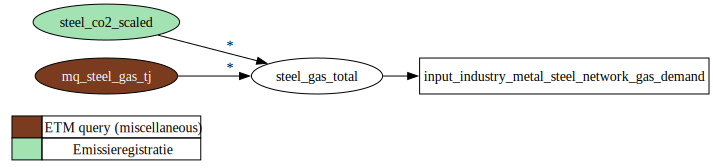

In [480]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_network_gas_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [481]:
# Generate commit message for metal steel network gas demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [482]:
# Calculate values for input_industry_metal_steel_network_gas_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_network_gas_demand  steel_gas_total  \
GM0014                                            0.0              0.0   
GM0034                                            0.0              0.0   
GM0037                                            0.0              0.0   
GM0047                                            0.0              0.0   
GM0050                                            0.0              0.0   
...                                               ...              ...   
GM1979                                            0.0              0.0   
GM1980                                            0.0              0.0   
GM1982                                            0.0              0.0   
GM1991                                            0.0              0.0   
GM1992                                            0.0              0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [483]:
# Add data to template for input_industry_metal_steel_network_gas_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [484]:
# Validate data for input_industry_metal_steel_network_gas_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_network_gas_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 7631.722757338105, 'mean_value': 22.413618847181905, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [485]:
# Verify data for input_industry_metal_steel_network_gas_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_network_gas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=7631.72, Mean=22.68
  Verification: Min=0.00, Max=11273.14, Mean=33.45
  Abs diff:     Min=0.00, Max=3641.42, Mean=10.82

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=7631.72, Verification=11273.14, Diff=364

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel steam hot water demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

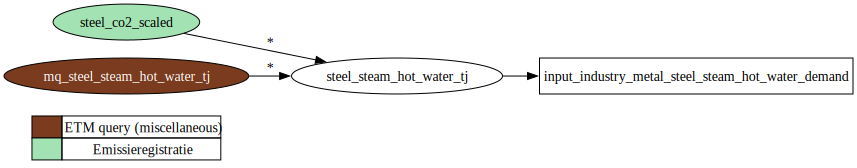

In [486]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_steam_hot_water_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [487]:
# Generate commit message for metal steel steam hot water demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [488]:
# Calculate values for input_industry_metal_steel_steam_hot_water_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_steam_hot_water_demand  \
GM0014                                                0.0   
GM0034                                                0.0   
GM0037                                                0.0   
GM0047                                                0.0   
GM0050                                                0.0   
...                                                   ...   
GM1979                                                0.0   
GM1980                                                0.0   
GM1982                                                0.0   
GM1991                                                0.0   
GM1992                                                0.0   

        steel_steam_hot_water_tj error_message  \
GM0014                       0.0           NaN   
GM0034                       0.0           NaN   
GM0037                       0.0           NaN   
GM0047                       0.0           NaN   
GM0050                       0.0           NaN   
...                          ...           ...   
GM1979                       0.0           NaN   
GM1980                       0.0           NaN   
GM1982                       0.0           NaN   
GM1991                       0.0           NaN   
GM1992                       0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [489]:
# Add data to template for input_industry_metal_steel_steam_hot_water_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [490]:
# Validate data for input_industry_metal_steel_steam_hot_water_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_steam_hot_water_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 1272.348884034434, 'mean_value': 3.7367634850157896, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [491]:
# Verify data for input_industry_metal_steel_steam_hot_water_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_steam_hot_water_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1272.35, Mean=3.78
  Verification: Min=0.00, Max=216.01, Mean=0.64
  Abs diff:     Min=0.00, Max=1056.34, Mean=3.14

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=1272.35, Verification=216.01, Diff=1056.3

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel crude oil demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

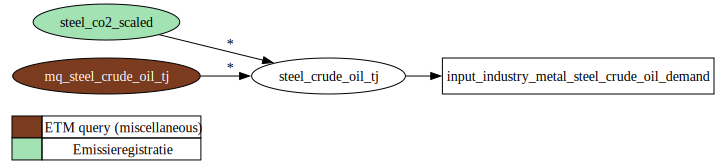

In [492]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_crude_oil_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [493]:
# Generate commit message for metal steel crude oil demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [494]:
# Calculate values for input_industry_metal_steel_crude_oil_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_crude_oil_demand  steel_crude_oil_tj  \
GM0014                                          0.0                 0.0   
GM0034                                          0.0                 0.0   
GM0037                                          0.0                 0.0   
GM0047                                          0.0                 0.0   
GM0050                                          0.0                 0.0   
...                                             ...                 ...   
GM1979                                          0.0                 0.0   
GM1980                                          0.0                 0.0   
GM1982                                          0.0                 0.0   
GM1991                                          0.0                 0.0   
GM1992                                          0.0                 0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [495]:
# Add data to template for input_industry_metal_steel_crude_oil_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [496]:
# Validate data for input_industry_metal_steel_crude_oil_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_crude_oil_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 66.14163081874368, 'mean_value': 0.19425146198830442, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [497]:
# Verify data for input_industry_metal_steel_crude_oil_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_crude_oil_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 8 municipalities (2.4%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=66.14, Mean=0.20
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=66.14, Mean=0.20

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=66.14, Verification=0.00, Diff=66.14 (0.0%)
  Municipality GM0482: Template=0.23, Verificat

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### metal steel wood pellets demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

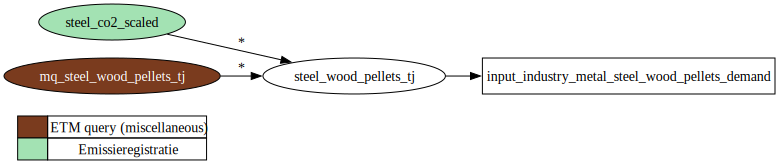

In [498]:
# Define ETLocal key
etlocal_key = "input_industry_metal_steel_wood_pellets_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [499]:
# Generate commit message for metal steel wood pellets demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [500]:
# Calculate values for input_industry_metal_steel_wood_pellets_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_industry_metal_steel_wood_pellets_demand  steel_wood_pellets_tj  \
GM0014                                             0.0                    0.0   
GM0034                                             0.0                    0.0   
GM0037                                             0.0                    0.0   
GM0047                                             0.0                    0.0   
GM0050                                             0.0                    0.0   
...                                                ...                    ...   
GM1979                                             0.0                    0.0   
GM1980                                             0.0                    0.0   
GM1982                                             0.0                    0.0   
GM1991                                             0.0                    0.0   
GM1992                                             0.0                    0.0   

       error_message                                             commit  
GM0014           NaN  Regionalisation of national data (retrieved fr...  
GM0034           NaN  Regionalisation of national data (retrieved fr...  
GM0037           NaN  Regionalisation of national data (retrieved fr...  
GM0047           NaN  Regionalisation of national data (retrieved fr...  
GM0050           NaN  Regionalisation of national data (retrieved fr...  
...              ...                                                ...  
GM1979           NaN  Regionalisation of national data (retrieved fr...  
GM1980           NaN  Regionalisation of national data (retrieved fr...  
GM1982           NaN  Regionalisation of national data (retrieved fr...  
GM1991           NaN  Regionalisation of national data (retrieved fr...  
GM1992           NaN  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [501]:
# Add data to template for input_industry_metal_steel_wood_pellets_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [502]:
# Validate data for input_industry_metal_steel_wood_pellets_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_industry_metal_steel_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [503]:
# Verify data for input_industry_metal_steel_wood_pellets_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_industry_metal_steel_wood_pellets_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.00, Mean=0.00
  Verification: Min=0.00, Max=0.00, Mean=0.00
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.00, Verification=0.00, Diff=0.00 (0.0%)
  Municipal

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### cokesoven transformation coal input demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

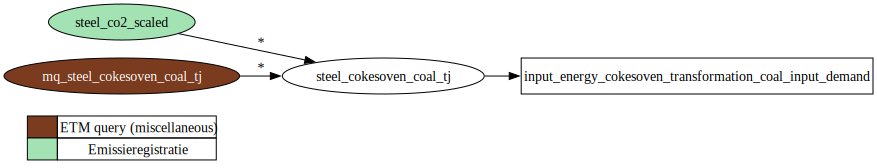

In [504]:
# Define ETLocal key
etlocal_key = "input_energy_cokesoven_transformation_coal_input_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [505]:
# Generate commit message for cokesoven transformation coal input demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [506]:
# Calculate values for input_energy_cokesoven_transformation_coal_input_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_energy_cokesoven_transformation_coal_input_demand  \
GM0014                                                0.0         
GM0034                                                0.0         
GM0037                                                0.0         
GM0047                                                0.0         
GM0050                                                0.0         
...                                                   ...         
GM1979                                                0.0         
GM1980                                                0.0         
GM1982                                                0.0         
GM1991                                                0.0         
GM1992                                                0.0         

        steel_cokesoven_coal_tj error_message  \
GM0014                      0.0           NaN   
GM0034                      0.0           NaN   
GM0037                      0.0           NaN   
GM0047                      0.0           NaN   
GM0050                      0.0           NaN   
...                         ...           ...   
GM1979                      0.0           NaN   
GM1980                      0.0           NaN   
GM1982                      0.0           NaN   
GM1991                      0.0           NaN   
GM1992                      0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [507]:
# Add data to template for input_energy_cokesoven_transformation_coal_input_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [508]:
# Validate data for input_energy_cokesoven_transformation_coal_input_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_energy_cokesoven_transformation_coal_input_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 67367.76626505305, 'mean_value': 197.8525011536977, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [509]:
# Verify data for input_energy_cokesoven_transformation_coal_input_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_energy_cokesoven_transformation_coal_input_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=67367.77, Mean=200.19
  Verification: Min=0.00, Max=76030.78, Mean=225.62
  Abs diff:     Min=0.00, Max=8663.01, Mean=25.83

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM045

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### blastfurnace transformation coal input demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

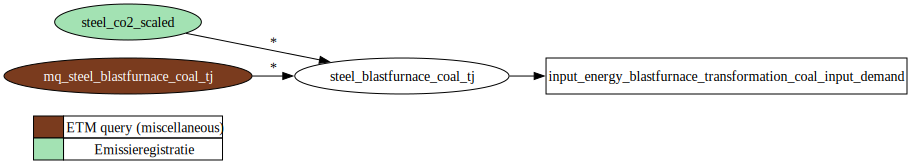

In [510]:
# Define ETLocal key
etlocal_key = "input_energy_blastfurnace_transformation_coal_input_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [511]:
# Generate commit message for blastfurnace transformation coal input demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [512]:
# Calculate values for input_energy_blastfurnace_transformation_coal_input_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_energy_blastfurnace_transformation_coal_input_demand  \
GM0014                                                0.0            
GM0034                                                0.0            
GM0037                                                0.0            
GM0047                                                0.0            
GM0050                                                0.0            
...                                                   ...            
GM1979                                                0.0            
GM1980                                                0.0            
GM1982                                                0.0            
GM1991                                                0.0            
GM1992                                                0.0            

        steel_blastfurnace_coal_tj error_message  \
GM0014                         0.0           NaN   
GM0034                         0.0           NaN   
GM0037                         0.0           NaN   
GM0047                         0.0           NaN   
GM0050                         0.0           NaN   
...                            ...           ...   
GM1979                         0.0           NaN   
GM1980                         0.0           NaN   
GM1982                         0.0           NaN   
GM1991                         0.0           NaN   
GM1992                         0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [513]:
# Add data to template for input_energy_blastfurnace_transformation_coal_input_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [514]:
# Validate data for input_energy_blastfurnace_transformation_coal_input_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_energy_blastfurnace_transformation_coal_input_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 28140.105205366974, 'mean_value': 82.64472026139042, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [515]:
# Verify data for input_energy_blastfurnace_transformation_coal_input_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_energy_blastfurnace_transformation_coal_input_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=28140.11, Mean=83.62
  Verification: Min=0.00, Max=42509.39, Mean=126.15
  Abs diff:     Min=0.00, Max=14369.29, Mean=42.68

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=28140.11, Verification=4

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### blastfurnace transformation cokes input demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

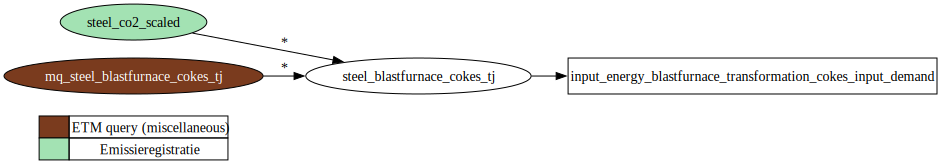

In [516]:
# Define ETLocal key
etlocal_key = "input_energy_blastfurnace_transformation_cokes_input_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [517]:
# Generate commit message for blastfurnace transformation cokes input demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [518]:
# Calculate values for input_energy_blastfurnace_transformation_cokes_input_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_energy_blastfurnace_transformation_cokes_input_demand  \
GM0014                                                0.0             
GM0034                                                0.0             
GM0037                                                0.0             
GM0047                                                0.0             
GM0050                                                0.0             
...                                                   ...             
GM1979                                                0.0             
GM1980                                                0.0             
GM1982                                                0.0             
GM1991                                                0.0             
GM1992                                                0.0             

        steel_blastfurnace_cokes_tj error_message  \
GM0014                          0.0           NaN   
GM0034                          0.0           NaN   
GM0037                          0.0           NaN   
GM0047                          0.0           NaN   
GM0050                          0.0           NaN   
...                             ...           ...   
GM1979                          0.0           NaN   
GM1980                          0.0           NaN   
GM1982                          0.0           NaN   
GM1991                          0.0           NaN   
GM1992                          0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [519]:
# Add data to template for input_energy_blastfurnace_transformation_cokes_input_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [520]:
# Validate data for input_energy_blastfurnace_transformation_cokes_input_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_energy_blastfurnace_transformation_cokes_input_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 35387.576669594884, 'mean_value': 103.92983086749038, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [521]:
# Verify data for input_energy_blastfurnace_transformation_cokes_input_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_energy_blastfurnace_transformation_cokes_input_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=35387.58, Mean=105.16
  Verification: Min=0.00, Max=53631.55, Mean=159.15
  Abs diff:     Min=0.00, Max=18243.97, Mean=54.18

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=35387.58, Verification

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


In [522]:
df_input_vars.columns

Index(['Gemeentenaam', 'ProvinciecodePV', 'Provincienaam', 'no_inhabitants',
       'no_residences', 'no_cars', 'total_energy_tj', 'tp_total_energy_tj',
       'total_electricity_tj', 'total_gas_heat_tj_temp_corrected',
       ...
       'index', 'aluminium_co2_scaled', 'index_dup', 'fertilizers_co2_scaled',
       'index_dup.1', 'refineries_co2_scaled', 'index_dup.2',
       'steel_co2_scaled', 'agriculture_gas_chp_relative',
       'agriculture_gas_final_demand_relative'],
      dtype='object', length=1898)

##### power combined cycle coal gas coal gas input demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

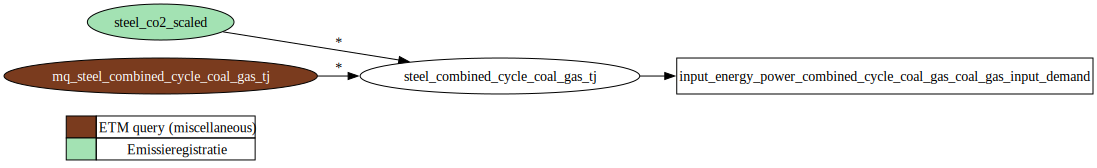

In [523]:
# Define ETLocal key
etlocal_key = "input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [524]:
# Generate commit message for power combined cycle coal gas coal gas input demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [525]:
# Calculate values for input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand  \
GM0014                                                0.0                  
GM0034                                                0.0                  
GM0037                                                0.0                  
GM0047                                                0.0                  
GM0050                                                0.0                  
...                                                   ...                  
GM1979                                                0.0                  
GM1980                                                0.0                  
GM1982                                                0.0                  
GM1991                                                0.0                  
GM1992                                                0.0                  

        steel_combined_cycle_coal_gas_tj error_message  \
GM0014                               0.0           NaN   
GM0034                               0.0           NaN   
GM0037                               0.0           NaN   
GM0047                               0.0           NaN   
GM0050                               0.0           NaN   
...                                  ...           ...   
GM1979                               0.0           NaN   
GM1980                               0.0           NaN   
GM1982                               0.0           NaN   
GM1991                               0.0           NaN   
GM1992                               0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [526]:
# Add data to template for input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [527]:
# Validate data for input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 15628.895804883798, 'mean_value': 45.90052923976605, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [528]:
# Verify data for input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_energy_power_combined_cycle_coal_gas_coal_gas_input_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  medium_diff: 1 municipalities (0.3%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=15628.90, Mean=46.44
  Verification: Min=0.00, Max=14506.15, Mean=43.05
  Abs diff:     Min=0.00, Max=1122.74, Mean=3.40

 TOP 10 LARGEST DIFFERENCES:
  Municipality

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### CHP coal gas coal gas input demand

1. Generate image

- *Action*: assign the corresponding `etlocal_key`

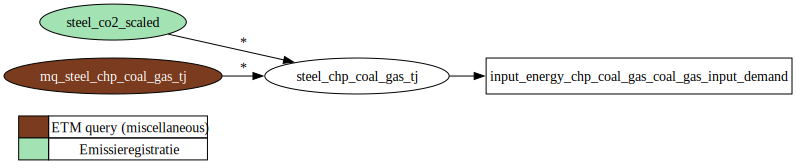

In [529]:
# Define ETLocal key
etlocal_key = "input_energy_chp_coal_gas_coal_gas_input_demand"

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

2. Generate commit message

- *Action*: create appropriate commit message for this key

In [530]:
# Generate commit message for chp coal gas coal gas input demand
message = generate_commit_message("Steel")

3. Calculate etlocal_key values

- *Action*: use the YamlCalculator to compute values

In [531]:
# Calculate values for input_energy_chp_coal_gas_coal_gas_input_demand
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=df_input_vars)
df_pipeline['commit'] = message
df_pipeline

input_energy_chp_coal_gas_coal_gas_input_demand  \
GM0014                                              0.0   
GM0034                                              0.0   
GM0037                                              0.0   
GM0047                                              0.0   
GM0050                                              0.0   
...                                                 ...   
GM1979                                              0.0   
GM1980                                              0.0   
GM1982                                              0.0   
GM1991                                              0.0   
GM1992                                              0.0   

        steel_chp_coal_gas_tj error_message  \
GM0014                    0.0           NaN   
GM0034                    0.0           NaN   
GM0037                    0.0           NaN   
GM0047                    0.0           NaN   
GM0050                    0.0           NaN   
...                       ...           ...   
GM1979                    0.0           NaN   
GM1980                    0.0           NaN   
GM1982                    0.0           NaN   
GM1991                    0.0           NaN   
GM1992                    0.0           NaN   

                                                   commit  
GM0014  Regionalisation of national data (retrieved fr...  
GM0034  Regionalisation of national data (retrieved fr...  
GM0037  Regionalisation of national data (retrieved fr...  
GM0047  Regionalisation of national data (retrieved fr...  
GM0050  Regionalisation of national data (retrieved fr...  
...                                                   ...  
GM1979  Regionalisation of national data (retrieved fr...  
GM1980  Regionalisation of national data (retrieved fr...  
GM1982  Regionalisation of national data (retrieved fr...  
GM1991  Regionalisation of national data (retrieved fr...  
GM1992  Regionalisation of national data (retrieved fr...  

[342 rows x 4 columns]

4. Add data to template

- *Action*: fill template with calculated values

In [532]:
# Add data to template for input_energy_chp_coal_gas_coal_gas_input_demand
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local, df_pipeline, etlocal_key=etlocal_key)

5. Validate data

- *Action*: perform data quality checks

In [533]:
# Validate data for input_energy_chp_coal_gas_coal_gas_input_demand
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")

Validation results: {'key': 'input_energy_chp_coal_gas_coal_gas_input_demand', 'total_rows': 342, 'zero_count': 334, 'nan_count': 0, 'min_value': 0.0, 'max_value': 2461.184701332243, 'mean_value': 7.228257309941509, 'median_value': 0.0}


6. Verify data

- *Action*: compare with verification dataset

In [534]:
# Verify data for input_energy_chp_coal_gas_coal_gas_input_demand
verification_results = src.helper.compare_template_with_verification(df_template_local, etlocal_key)
print("Verification completed.")


MUNICIPALITY COMPARISON FOR KEY: input_energy_chp_coal_gas_coal_gas_input_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 330 municipalities (97.6%)
  small_diff: 6 municipalities (1.8%)
  large_diff: 2 municipalities (0.6%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2461.18, Mean=7.31
  Verification: Min=0.00, Max=8295.07, Mean=24.62
  Abs diff:     Min=0.00, Max=5833.88, Mean=17.32

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0453: Template=2461.18, Verification=8295.07, Diff=5833

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


#### Heat and CHP

##### Gas CHP

In [535]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_combined_cycle_gas_power_fuelmix_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_combined_cycle_gas_power_fuelmix_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Gas motor CHP

In [536]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_engine_gas_power_fuelmix_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_engine_gas_power_fuelmix_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Gas turbine CHP

In [537]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_turbine_gas_power_fuelmix_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_turbine_gas_power_fuelmix_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Coal CHP

In [538]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_ultra_supercritical_coal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_ultra_supercritical_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Biomass CHP

In [539]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_wood_pellets_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_wood_pellets_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Hydrogen turbine CHP

In [540]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_chp_turbine_hydrogen_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_chp_turbine_hydrogen_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Lignite-fired heater

In [541]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_heat_burner_lignite_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_heat_burner_lignite_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Coal-fired heater

In [542]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_heat_burner_coal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_heat_burner_coal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Geothermal heater

In [543]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_heat_well_geothermal_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_heat_well_geothermal_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Oil-fired heater

In [544]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_heat_burner_crude_oil_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_heat_burner_crude_oil_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Hydrogen heater

In [545]:
# Set oil demand to zero for all municipalities
etlocal_key = 'industry_heat_burner_hydrogen_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'industry_heat_burner_hydrogen_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


#### Non-energetic crude oil mix
The non-energetic crude oil mix is set to 100% crude oil in the municipal datasets

##### Diesel non-energetic


In [546]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_diesel_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_diesel_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Biodiesel non-energetic

In [547]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_biodiesel_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_biodiesel_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Kerosene non-energetic

In [548]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_kerosene_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_kerosene_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Bio-kerosene non-energetic

In [549]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_bio_kerosene_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_bio_kerosene_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### lpg non-energetic

In [550]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_lpg_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_lpg_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Bio-oil non-energetic

In [551]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_bio_oil_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_bio_oil_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


##### Crude oil non-energetic

In [552]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_percentage_of_crude_oil_industry_final_demand_crude_oil_non_energetic'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 1, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_percentage_of_crude_oil_industry_final_demand_crude_oil_non_energetic', 'total_rows': 342, 'zero_count': 0, 'nan_count': 0, 'min_value': 1.0, 'max_value': 1.0, 'mean_value': 1.0, 'median_value': 1.0}


##### Naphtha energetic --> Wrongly placed

In [553]:
# Set oil demand to zero for all municipalities
etlocal_key = 'input_industry_refinery_transformation_crude_oil_naphtha_demand'
df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)

# Validate the result
validation_results = src.helper.validate_template_data(df_template_local, etlocal_key)
print(f"Validation results: {validation_results}")


Validation results: {'key': 'input_industry_refinery_transformation_crude_oil_naphtha_demand', 'total_rows': 342, 'zero_count': 342, 'nan_count': 0, 'min_value': 0.0, 'max_value': 0.0, 'mean_value': 0.0, 'median_value': 0.0}


## Export
Write the resulting filled template to a csv

In [554]:
# Write the filled template to a CSV file
path_output = Path("data", "processed", f"etlocal_template_industry_filled.csv")
df_template_local.to_csv(path_output, sep=sep)